In [1]:
################################################################################################################################
#
# ECONOMETRIC - ROLLING - LN - DAILY
#
################################################################################################################################

In [2]:
#===============================================================================================================================
# ENVIRONMENT: LIBRARIES
#===============================================================================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pmdarima as pmd

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX

from typing import Union
from tqdm import tqdm_notebook
#from tqdm.notebook import tqdm

In [3]:
#===============================================================================================================================
# DATA: INPUT
#===============================================================================================================================
seriesId='IBOV'
df = pd.read_csv(seriesId+'.csv')
df.drop(['Open','Low','High', 'Qt'], axis='columns', inplace=True )
PERIOD=249
df

,Date,Close
0,03/01/2000,16930.42
1,04/01/2000,15851.00
2,05/01/2000,16245.14
3,06/01/2000,16106.89
4,07/01/2000,16309.15
...,...,...
5938,21/12/2023,132182.01
5939,22/12/2023,132752.93
5940,26/12/2023,133532.92
5941,27/12/2023,134193.72


In [4]:
#===============================================================================================================================
# DATA: PRICES - DATETIME
#===============================================================================================================================
df['Date'] =pd.to_datetime(df['Date'], dayfirst=True)

In [5]:
#===============================================================================================================================
# DATA: PRICES - SET INDEX
#===============================================================================================================================
df2 = df.set_index('Date')

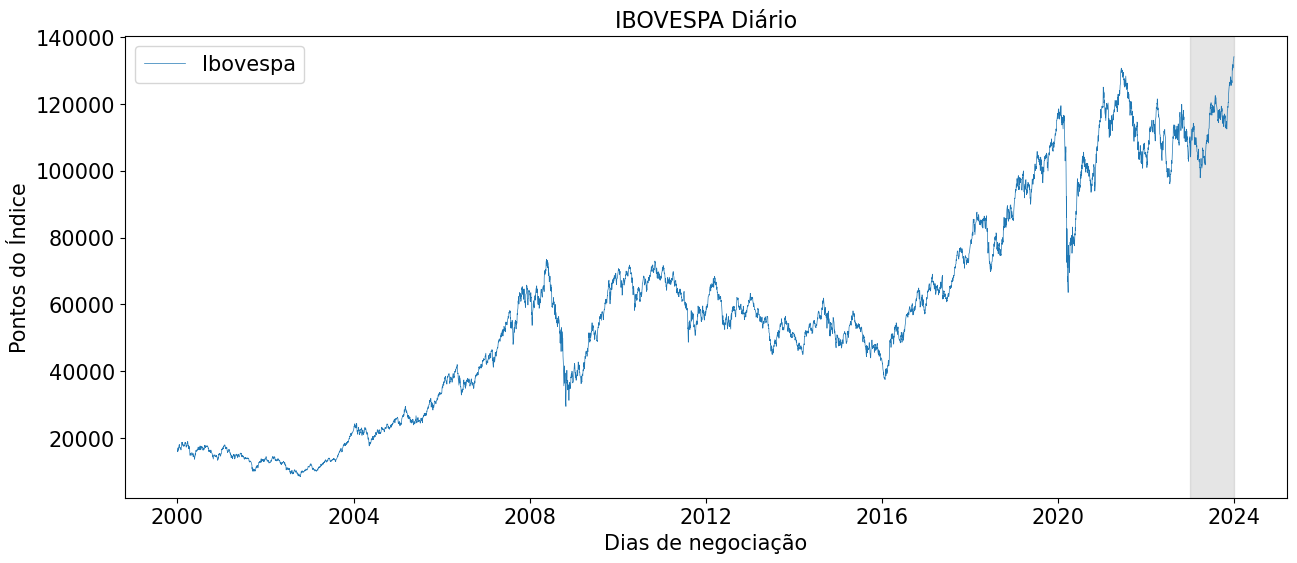

In [6]:
#===============================================================================================================================
# DATA: PRICES - PLOT
#===============================================================================================================================
plt.figure(figsize=(15,6))
plt.plot(df['Date'], df['Close'], label = 'Ibovespa', linewidth=0.5)
plt.title('IBOVESPA Diário', fontsize=16)
plt.xlabel('Dias de negociação', fontsize=15)
plt.ylabel('Pontos do Índice', fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.axvspan('2023', '2024', color='#808080', alpha=0.2)
plt.legend(loc=2, prop={'size': 15}, bbox_to_anchor=(0,1))
plt.show()


In [7]:
#===============================================================================================================================
# DATA: PREP - LOG
#===============================================================================================================================
dfln = df.copy()
dfln['CloseLn']= np.log(dfln['Close'])

In [8]:
#===============================================================================================================================
# DATA: PREP - LOG - SET INDEX
#===============================================================================================================================
dfln2 = dfln.set_index('Date')

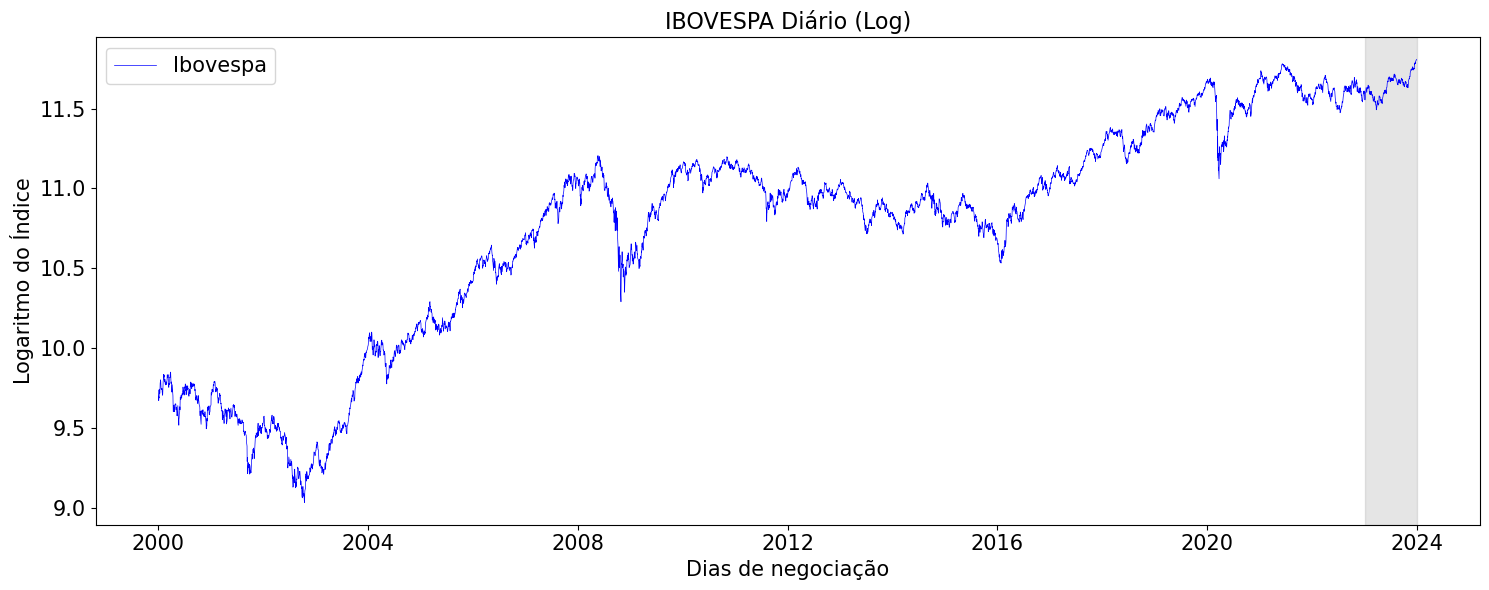

In [9]:
#===============================================================================================================================
# DATA: PREP - LOG - PLOT
#===============================================================================================================================
plt.figure(figsize=(15,6))
plt.plot(dfln['Date'], dfln['CloseLn'], 'b-', label = "Ibovespa", linewidth=0.5)
plt.title('IBOVESPA Diário (Log)', fontsize=16)
plt.xlabel('Dias de negociação', fontsize=15)
plt.ylabel('Logaritmo do Índice', fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.axvspan('2023', '2024', color='#808080', alpha=0.2)
plt.legend(loc=2, prop={'size': 15}, bbox_to_anchor=(0,1))
plt.tight_layout()
plt.show()

In [10]:
#===============================================================================================================================
# DATA: PREP - LOG-DIFF
#===============================================================================================================================
dfln['CloseLnDiff'] = 0
dfln.loc[1:, ['CloseLnDiff']] = dfln.loc[:, 'CloseLn'].diff()
dfln

,Date,Close,CloseLn,CloseLnDiff
0,2000-01-03,16930.42,9.736867,0.000000
1,2000-01-04,15851.00,9.670988,-0.065879
2,2000-01-05,16245.14,9.695549,0.024561
3,2000-01-06,16106.89,9.687002,-0.008547
4,2000-01-07,16309.15,9.699482,0.012479
...,...,...,...,...
5938,2023-12-21,132182.01,11.791935,0.010479
5939,2023-12-22,132752.93,11.796245,0.004310
5940,2023-12-26,133532.92,11.802103,0.005858
5941,2023-12-27,134193.72,11.807040,0.004936


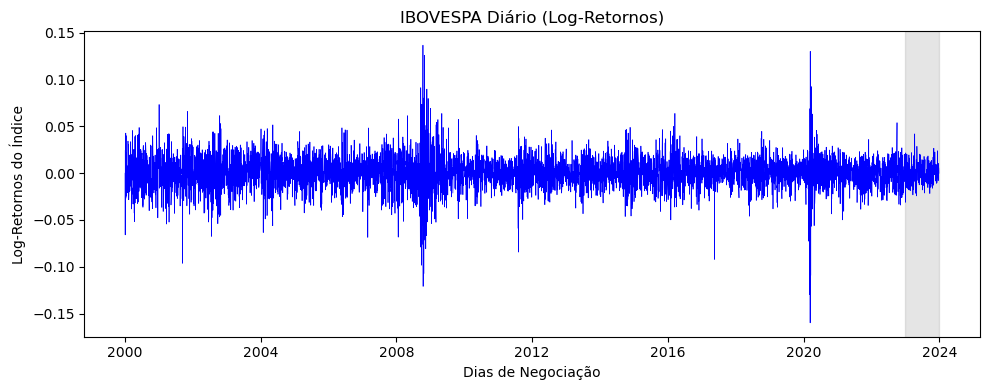

In [11]:
#===============================================================================================================================
# DATA: PREP - LOG-DIFF - PLOT
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 4))
plt.title('IBOVESPA Diário (Log-Retornos)', fontsize=12)
ax.plot(dfln['Date'], dfln['CloseLnDiff'], 'b-', label = "Log-Retornos do Índice", linewidth=0.5)
ax.set_xlabel('Dias de Negociação')
ax.set_ylabel('Log-Retornos do Índice')
ax.axvspan('2023', '2024', color='#808080', alpha=0.2)
plt.tight_layout()

In [12]:
#===============================================================================================================================
# DATA: PREP - SPLIT
#===============================================================================================================================
totallen = len(df)
trainlen = len(df2[:'2022'])
testlen  = len(df2['2023':])

trainfin = trainlen-1
testini  = trainlen

train = df[:testini]
test  = df[testini:]

print("Train Len", trainlen, "Length Total =", totallen, "| Train Fin =", trainfin, "| Test Ini =", testini)

Train Len 5695 Length Total = 5943 | Train Fin = 5694 | Test Ini = 5695


In [13]:
################################################################################################################################
# ROLLING FORECAST
################################################################################################################################
from statsmodels.tsa.statespace.sarimax import SARIMAX

#===============================================================================================================================
# ROLLING FORECAST: PARAMETERS
#===============================================================================================================================
HORIZON = len(test)
WINDOW = 1

#===============================================================================================================================
# ROLLING FORECAST: FUNCTION
#===============================================================================================================================
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str, orderparam=(0,0,0)) -> list:   
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean
    elif method == 'last':
        pred_last = []
        
        for i in range(train_len, total_len, window):
            last = df.loc[i]
            pred_last.extend(last for _ in range(window))
        return pred_last
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=orderparam)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
        
        model_fit = model.fit(disp=False)
        print(model_fit.summary())
        print("θ1 = {}, θ2 = {}".format(model_fit.params[0],model_fit.params[1]))
        return pred_MA
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=orderparam)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        model_fit = model.fit(disp=False)
        print(model_fit.summary())
        print("phi1 = {}, phi2 = {}".format(model_fit.params[0],model_fit.params[1]))
        return pred_AR
    elif method == 'ARMA':
        pred_ARMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=orderparam)  
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
            
        model_fit = model.fit(disp=False)
        print(model_fit.summary())
        print("θ = {}, σ2 = {}".format(model_fit.params[0],model_fit.params[1]))
        return pred_ARMA
    elif method == 'ARIMA':
        pred_ARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=orderparam)  
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARIMA.extend(oos_pred)
            
        model_fit = model.fit(disp=False)
        print(model_fit.summary())
        print("θ = {}, σ2 = {}".format(model_fit.params[0],model_fit.params[1]))
        return pred_ARIMA

In [14]:
################################################################################################################################
# BASELINE
################################################################################################################################

#===============================================================================================================================
# BASELINE: LOG - FORECAST - last, mean
#===============================================================================================================================
pred_LastLn = rolling_forecast(dfln['CloseLn'], trainfin, HORIZON, WINDOW, 'last')
pred_MeanLn = rolling_forecast(dfln['CloseLn'], trainfin+1, HORIZON, WINDOW, 'mean')

#===============================================================================================================================
# BASELINE: LOG - COPY testln - last, mean 
#===============================================================================================================================
testln = dfln.loc[trainfin:,['Date','CloseLn']]
testln.loc[testini:,'pred_LastLn'] = pred_LastLn
testln.loc[testini:,'pred_MeanLn'] = pred_MeanLn

In [15]:
#===============================================================================================================================
# BASELINE: LOG - COPY dfln - last, mean 
#===============================================================================================================================
dfln['pred_LastLn'] = 0.0
dfln['pred_MeanLn'] = 0.0

dfln.loc[testini:,'pred_LastLn']=testln.loc[testini:,'pred_LastLn']
dfln.loc[testini:,'pred_MeanLn']=testln.loc[testini:,'pred_MeanLn']

In [16]:
#===============================================================================================================================
# BASELINE: LOG - PERFORMANCE - last, mean
#===============================================================================================================================
mse_Last   = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_LastLn'])
mse_Mean   = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_MeanLn'])

data_metrics = [['Last'  , "{:,}".format(round(mse_Last,4))  , "{:,}".format(round(sqrt(mse_Last),4))] ,
                ['Mean'  , "{:,}".format(round(mse_Mean,4))  , "{:,}".format(round(sqrt(mse_Mean),4))] ]

df_metrics   = pd.DataFrame(data_metrics, columns=['Log', 'MSE', 'RMSE'])

Text(0, 0.5, 'Log')

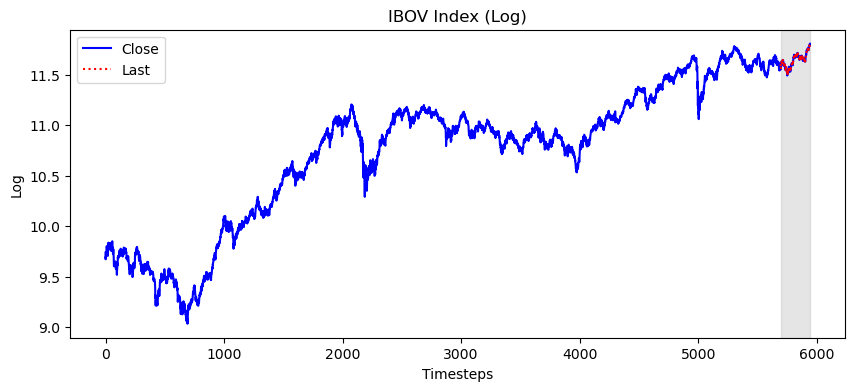

In [17]:
#===============================================================================================================================
# BASELINE: LOG - PLOT
#===============================================================================================================================
fig, (ax3) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 4))

plt.title(seriesId+' Index (Log)', fontsize=12)
ax3.plot(dfln['CloseLn'], 'b-', label='Close')
ax3.plot(dfln.loc[testini:,'pred_LastLn'], 'r:', label='Last')
#ax3.plot(dfln.loc[testini:,'pred_MeanLn'], 'k-', label='Mean')
ax3.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax3.legend(loc=2)
ax3.set_xlabel('Timesteps')
ax3.set_ylabel('Log')

Text(0, 0.5, 'Log')

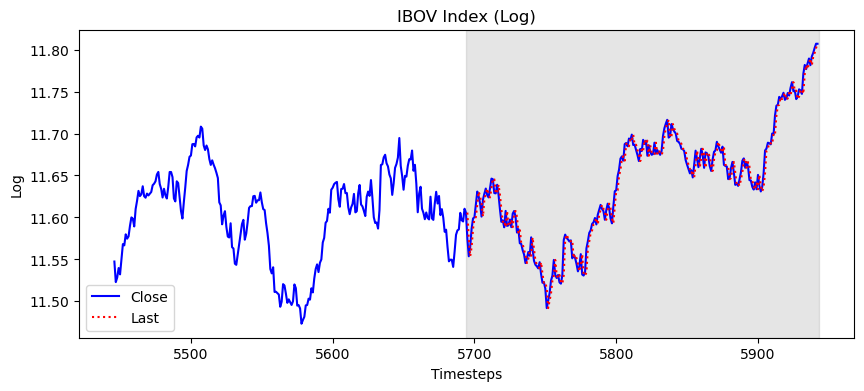

In [18]:
#===============================================================================================================================
# BASELINE: LOG - Plot (zoom)
#===============================================================================================================================
fig, (ax3) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 4))

plt.title(seriesId+' Index (Log)', fontsize=12)
ax3.plot(dfln.loc[trainfin-testlen:,'CloseLn'    ], 'b-', label='Close')
ax3.plot(dfln.loc[testini:  ,'pred_LastLn'], 'r:', label='Last')
#ax3.plot(dfln.loc[testini:  ,'pred_MeanLn'], 'k-', label='Mean')
ax3.axvspan(trainfin, totallen, color='#808080', alpha=0.2)
ax3.legend(loc=3)
ax3.set_xlabel('Timesteps')
ax3.set_ylabel('Log')

In [19]:
#===============================================================================================================================
# BASELINE: PRICES - RECOVER
#===============================================================================================================================
df['pred_Last'] = 0.0
df['pred_Mean'] = 0.0


pred_Last = rolling_forecast(dfln['Close'], trainfin, HORIZON, WINDOW, 'last')
pred_Mean = rolling_forecast(dfln['Close'], trainfin+1, HORIZON, WINDOW, 'mean')

df.loc[testini:,'pred_Last']= pred_Last
df.loc[testini:,'pred_Mean']= np.round(pred_Mean,2)

In [20]:
#===============================================================================================================================
# BASELINE: PRICES - RECOVER - PERFORMANCE
#===============================================================================================================================
mse_Last = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_Last'])
mse_Mean = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_Mean'])

data_metrics = [['Last'  , "{:,}".format(round(mse_Last,))  , "{:,}".format(round(sqrt(mse_Last),1))] ,
                ['Mean'  , "{:,}".format(round(mse_Mean,))  , "{:,}".format(round(sqrt(mse_Mean),1))] ]

df_metrics   = pd.DataFrame(data_metrics, columns=['Price', 'MSE', 'RMSE'])
df_metrics

,Price,MSE,RMSE
0,Last,"1,476,001","1,214.9"
1,Mean,"3,357,125,693","57,940.7"


Text(0, 0.5, 'Prices')

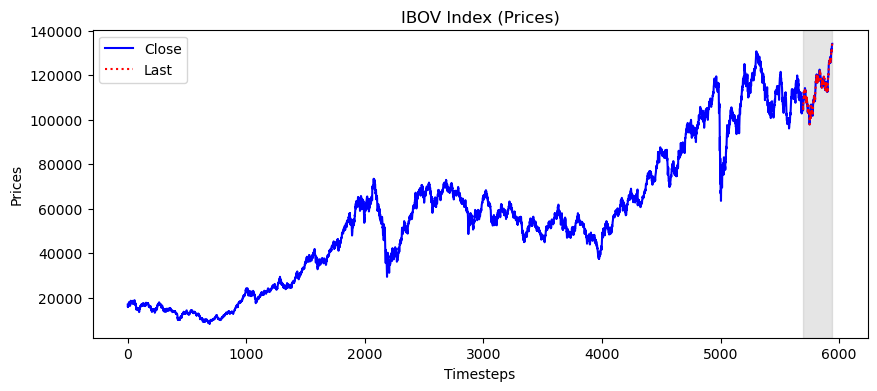

In [21]:
#===============================================================================================================================
# BASELINES: PRICES - RECOVER - PLOT
#===============================================================================================================================
fig, (ax3) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 4))
plt.title(seriesId+' Index (Prices)', fontsize=12)
ax3.plot(df['Close'], 'b-', label='Close')
ax3.plot(df.loc[testini+1:,'pred_Last'], 'r:', label='Last')
#ax3.plot(df.loc[testini+1:,'pred_Mean'], 'k-', label='Mean')
ax3.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax3.legend(loc=2)
ax3.set_xlabel('Timesteps')
ax3.set_ylabel('Prices')

Text(0, 0.5, 'Prices')

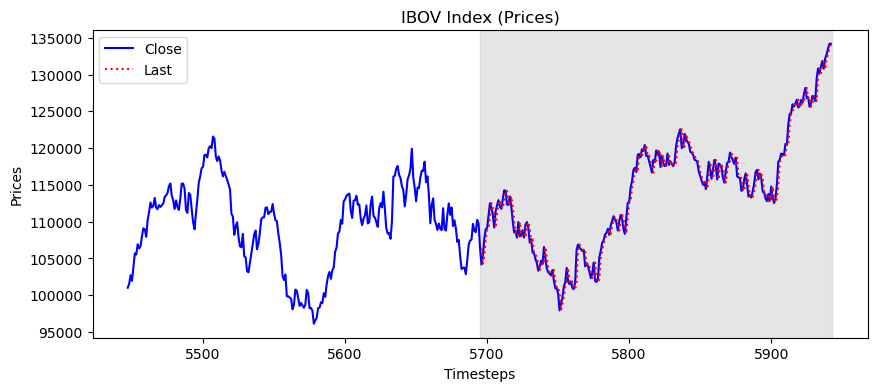

In [22]:
#===============================================================================================================================
# BASELINES: PRICES - RECOVER - PLOT (zoom)
#===============================================================================================================================
fig, (ax3) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 4))
plt.title(seriesId+' Index (Prices)', fontsize=12)
ax3.plot(df.loc[testini-testlen:,'Close'    ], 'b-', label='Close')
ax3.plot(df.loc[testini+1:  ,'pred_Last'], 'r:', label='Last')
#ax3.plot(df.loc[testini+1:  ,'pred_Mean'], 'k-', label='Mean')
ax3.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax3.legend(loc=2)
ax3.set_xlabel('Timesteps')
ax3.set_ylabel('Prices')

In [23]:
################################################################################################################################
# STATIONARITY
################################################################################################################################

#===============================================================================================================================
# STATIONARITY: LOG - ADF test
#===============================================================================================================================
ADF_Close = adfuller(dfln['CloseLn'])
print(f'ADF Statistic: {np.round(ADF_Close[0],3)}')
print(f'ADF p-value  : {np.round(ADF_Close[1],2)}')

#-------------------------------------------------------------------------------------------------------------------------------
# ADF Statistic: -0.999
# ADF p-value  : 0.75
#-------------------------------------------------------------------------------------------------------------------------------
# ***** NON-STATIONARY *****
#-------------------------------------------------------------------------------------------------------------------------------

ADF Statistic: -0.999
ADF p-value  : 0.75


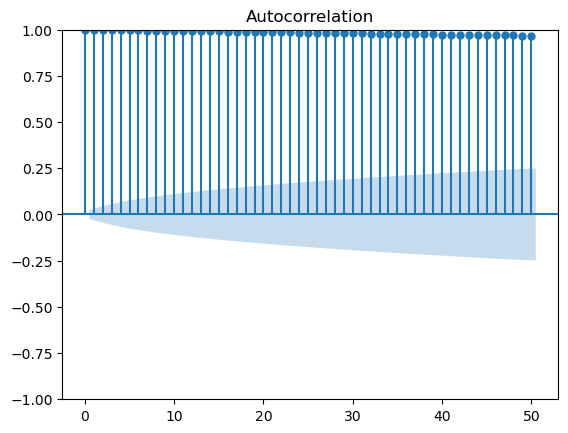

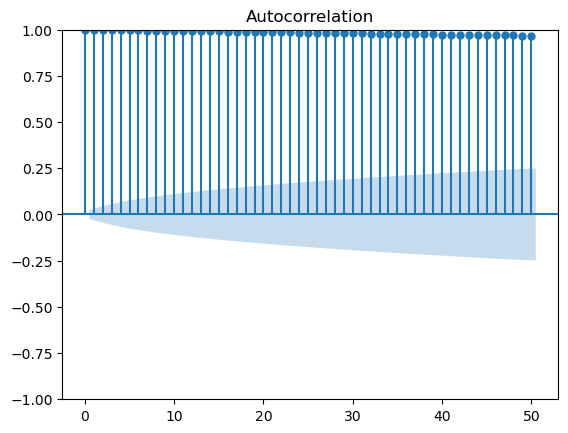

In [24]:
#===============================================================================================================================
# STATIONARITY: LOG - ACF plot
#===============================================================================================================================
plot_acf(dfln['CloseLn'], lags=50)

#-------------------------------------------------------------------------------------------------------------------------------
# Significant AC coefficients slowly decreasing after lag 0 
#-------------------------------------------------------------------------------------------------------------------------------
# ***** AUTOCORRELATION present ******
#-------------------------------------------------------------------------------------------------------------------------------

#===============================================================================================================================
# DATA STATIONARITY: LOG - ADF test + ACF plot
#===============================================================================================================================
#-------------------------------------------------------------------------------------------------------------------------------
# ***** NO RANDOM-WALK *****
#-------------------------------------------------------------------------------------------------------------------------------

In [25]:
#===============================================================================================================================
# STATIONARITY: LOG-RET - ADF test
#===============================================================================================================================
ADF_Close = adfuller(dfln['CloseLnDiff'])
print(f'ADF Statistic: {np.round(ADF_Close[0],3)}')
print(f'ADF p-value  : {np.round(ADF_Close[1],2)}')
#-------------------------------------------------------------------------------------------------------------------------------
# ADF Statistic: -16.892
# ADF p-value  : 0.0
# Null hypothesis rejected - No Unit Root
#-------------------------------------------------------------------------------------------------------------------------------
# ***** STATIONARY *****
#-------------------------------------------------------------------------------------------------------------------------------

ADF Statistic: -16.892
ADF p-value  : 0.0


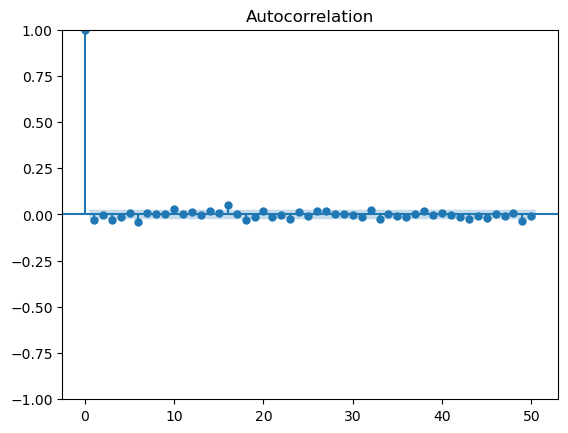

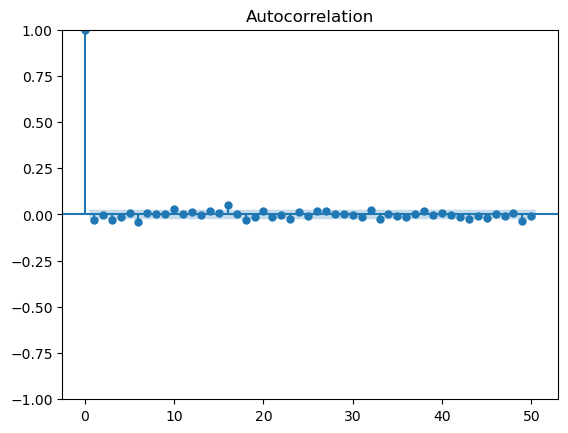

In [26]:
#===============================================================================================================================
# STATIONARITY: LOG-RET - ACF plot
#===============================================================================================================================
plot_acf(dfln['CloseLnDiff'], lags=50)
#-------------------------------------------------------------------------------------------------------------------------------
# No Significant AC coefficients after lag 0 
#-------------------------------------------------------------------------------------------------------------------------------
# ***** NO AUTOCORRELATION *****
#-------------------------------------------------------------------------------------------------------------------------------

#===============================================================================================================================
# DATA STATIONARITY: LOG-RET - ADF test + ACF plot
#===============================================================================================================================
#-------------------------------------------------------------------------------------------------------------------------------
# ***** RANDOM WALK *****
#-------------------------------------------------------------------------------------------------------------------------------

In [27]:
###############################################################################################################################
#
# MA - MOVING AVERAGE 
#
###############################################################################################################################

In [28]:
#===============================================================================================================================
# MA
#
# LOG: NON-STATIONARY (ADF Test & ACF Autocorrelation present)
# LOG-RET: STATIONARY (ADF Test & ACF Almost no Autocorrelation) => RANDOM WALK
#           ACF Coefficients don't become abruptly non-significant => No MOVING AVERAGE
#           ACF No Significant Coefficients after lag 0: 1,3,*6,10,*16,18
#===============================================================================================================================

#-------------------------------------------------------------------------------------------------------------------------------
# ***** LOG-DIFF: STATIONARY + NO AUTOCORRELATION => RANDOM WALK => NO MOVING AVERAGE *****
#-------------------------------------------------------------------------------------------------------------------------------

In [29]:
#===============================================================================================================================
# MA: LOG-RET - FORECAST
#===============================================================================================================================
pred_MALnDiff = rolling_forecast(dfln['CloseLnDiff'], testini, HORIZON, WINDOW, 'MA',(0,0,1))

C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

                               SARIMAX Results                                
Dep. Variable:            CloseLnDiff   No. Observations:                 5942
Model:               SARIMAX(0, 0, 1)   Log Likelihood               15586.556
Date:                Mon, 02 Dec 2024   AIC                         -31169.112
Time:                        15:13:51   BIC                         -31155.732
Sample:                             0   HQIC                        -31164.463
                               - 5942                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0270      0.007     -3.970      0.000      -0.040      -0.014
sigma2         0.0003   2.78e-06    110.711      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.01   Jarque-

In [30]:
#===============================================================================================================================
# MA: LOG-RET - STORE PRED, SAVE EXCEL
#===============================================================================================================================
testln.loc[testini:,'pred_MALnDiff'] = 0
testln.loc[testini:,'pred_MALnDiff'] = pred_MALnDiff
testln.loc[testini:,'pred_MALnDiff'].to_excel('Data/Output/Rolling-Ln-Daily-MALnDiff.xlsx')

In [31]:
#===============================================================================================================================
# MA: LOG-RET - PERFORMANCE
#===============================================================================================================================
mse_MA     = mean_squared_error(dfln.loc[testini:,'CloseLnDiff'], testln.loc[testini:,'pred_MALnDiff'])
data_metrics = [['MA'    , "{:,}".format(round(mse_MA,  6))  , "{:,}".format(round(sqrt(mse_MA)  ,6))] ]
df_metrics = pd.DataFrame(data_metrics, columns=['Log Diff', 'MSE', 'RMSE'])

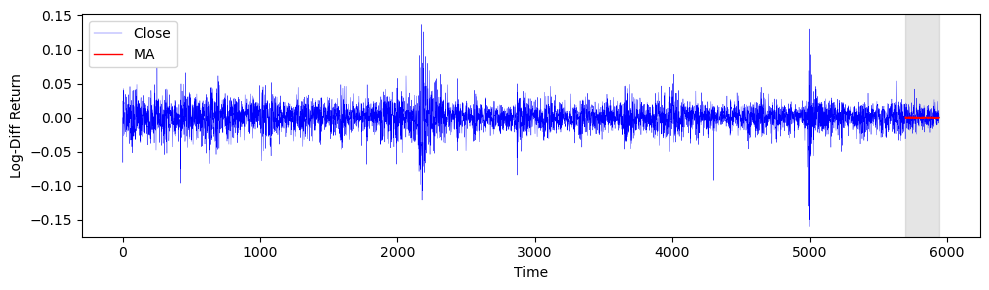

In [32]:
#===============================================================================================================================
# MA: LOG-RET - PLOT
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(dfln.loc[:testini+1,'CloseLnDiff']        ,'b-', linewidth=0.25) 
ax.plot(dfln.loc[testini+1:totallen,'CloseLnDiff'],'b-', linewidth=0.25, label='Close')
ax.plot(testln.loc[:totallen,'pred_MALnDiff']     ,'r-', linewidth=1.0, label='MA')
ax.axvspan(testini,totallen, color='#808080', alpha=0.2)
ax.legend(loc=2)
#plt.xticks([ testini-testlen, testini],           ['2022'          , '2023'])
ax.set_xlabel('Time')
ax.set_ylabel('Log-Diff Return')
plt.tight_layout()

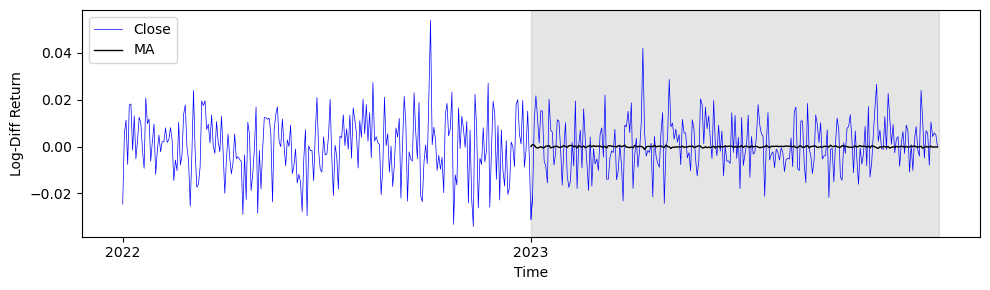

In [33]:
#===============================================================================================================================
# MA: LOG-RET - PLOT (zoom)
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(dfln.loc[testini-testlen:testini+1,'CloseLnDiff'],'b-', linewidth=0.5) 
ax.plot(dfln.loc[testini:totallen,'CloseLnDiff']         ,'b-', linewidth=0.5, label='Close')
ax.plot(testln.loc[testini:totallen,'pred_MALnDiff']     ,'k-', linewidth=1.0, label='MA')
ax.axvspan(testini,totallen, color='#808080', alpha=0.2)
ax.legend(loc=2)
plt.xticks([ testini-testlen, testini],           ['2022'          , '2023'])
ax.set_xlabel('Time')
ax.set_ylabel('Log-Diff Return')
plt.tight_layout()

In [34]:
#===============================================================================================================================
# MA: LOG - RECOVER
#===============================================================================================================================
dfln['pred_MALn'] = 0.0
dfln.loc[testini:,'pred_MALn'] = dfln.shift(periods=1).loc[testini:, 'CloseLn'] + testln.loc[testini:,'pred_MALnDiff']
#dfln.loc[:,'pred_MALn'].to_excel('Data/Output/Rolling-Ln-Daily-MALn.xlsx')
dfln[testini-1:]

,Date,Close,CloseLn,CloseLnDiff,pred_LastLn,pred_MeanLn,pred_MALn
5694,2022-12-29,109734.60,11.605820,-0.004565,0.000000,0.000000,0.000000
5695,2023-01-02,106376.02,11.574735,-0.031085,11.605820,10.729549,11.605938
5696,2023-01-03,104165.74,11.553739,-0.020997,11.574735,10.729697,11.575626
5697,2023-01-04,105334.46,11.564896,0.011157,11.553739,10.729842,11.554354
5698,2023-01-05,107641.32,11.586560,0.021664,11.564896,10.729988,11.564598
...,...,...,...,...,...,...,...
5938,2023-12-21,132182.01,11.791935,0.010479,11.781457,10.766810,11.781667
5939,2023-12-22,132752.93,11.796245,0.004310,11.791935,10.766983,11.791657
5940,2023-12-26,133532.92,11.802103,0.005858,11.796245,10.767156,11.796121
5941,2023-12-27,134193.72,11.807040,0.004936,11.802103,10.767330,11.801942


In [35]:
#===============================================================================================================================
# MA: LOG - PERFORMANCE
#===============================================================================================================================
mse_Last   = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_LastLn'])
mse_Mean   = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_MeanLn'])
mse_MA     = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_MALn'  ])

data_metrics = [['Last'  , "{:,}".format(round(mse_Last,6))  , "{:,}".format(round(sqrt(mse_Last),6))] ,
                ['Mean'  , "{:,}".format(round(mse_Mean,6))  , "{:,}".format(round(sqrt(mse_Mean),6))] ,
                ['MA'    , "{:,}".format(round(mse_MA,  6))  , "{:,}".format(round(sqrt(mse_MA)  ,6))] ]

df_metrics = pd.DataFrame(data_metrics, columns=['Log', 'MSE', 'RMSE'])

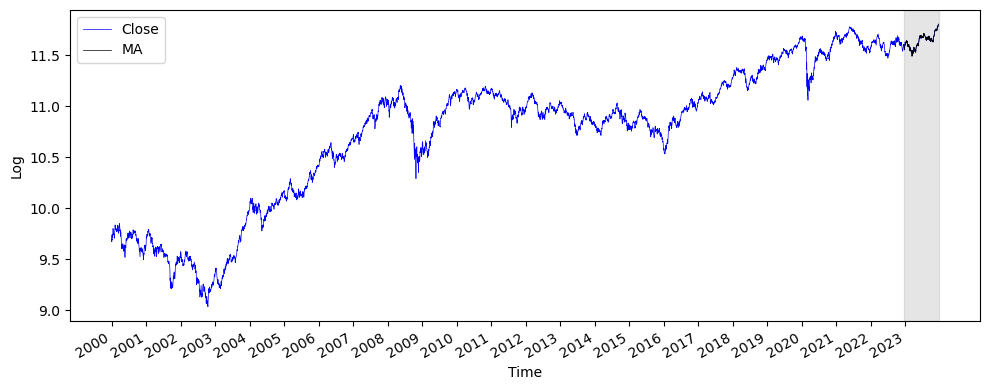

In [36]:
#===============================================================================================================================
# MA: LOG - PLOT
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(dfln['CloseLn'], 'b-', label='Close', lw=0.5)    
#ax.plot(dfln.loc[testini+1:,'pred_LastLn'], 'r-' , label='Last', lw=0.5)
#ax.plot(dfln.loc[testini+1:,'pred_MeanLn'], 'm-.', label='Mean', lw=0.5)
ax.plot(dfln.loc[testini+1:,'pred_MALn']  , 'k-' , label='MA'  , lw=0.5)   
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Log')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
#ax.set_xlim(testini, totallen)
plt.xticks(np.arange(0, totallen, testlen), np.arange(2000, 2024, 1))
fig.autofmt_xdate()
plt.tight_layout()

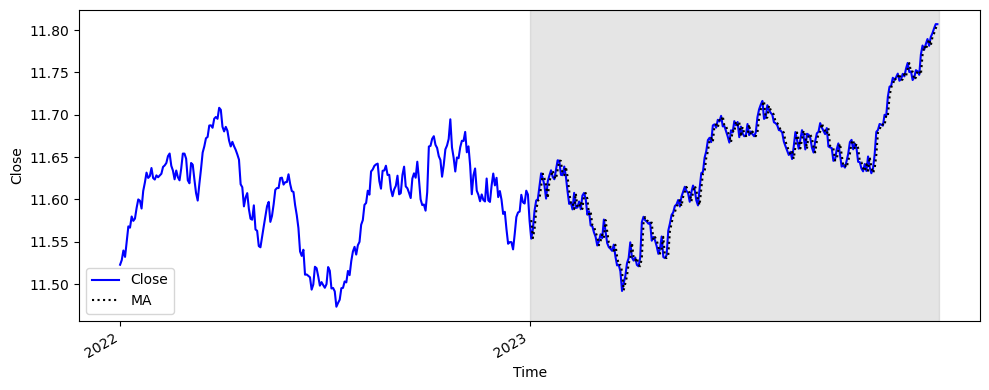

In [37]:
#===============================================================================================================================
# MA: LOG - PLOT (zoom)
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(dfln.loc[testini-testlen:,'CloseLn'] , 'b-' , label='Close')    
#ax.plot(dfln.loc[testini+1:,'pred_LastLn']  , 'r-' , label='Last')
#ax.plot(dfln.loc[testini+1:,'pred_MeanLn']  , 'y-.', label='Mean')
ax.plot(dfln.loc[testini+1:,'pred_MALn']    , 'k:' , label='MA')   

ax.legend(loc=3)
ax.set_xlabel('Time')
ax.set_ylabel('Close')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
#ax.set_xlim(testini, totallen)
plt.xticks([testini-testlen, testini],           ['2022'          , '2023'])
fig.autofmt_xdate()
plt.tight_layout()

In [38]:
#===============================================================================================================================
# MA: PRICE - RECOVER
#===============================================================================================================================
df['pred_MA'] = 0.0
df.loc[testini:,'pred_MA']= np.round(np.exp(dfln.loc[testini:,'pred_MALn']),2)
#df.loc[:,'pred_MA'].to_excel('Data/Output/Rolling-Ln-Daily-MA.xlsx')
df[testini-1:]

,Date,Close,pred_Last,pred_Mean,pred_MA
5694,2022-12-29,109734.60,0.00,0.00,0.00
5695,2023-01-02,106376.02,109734.60,55564.15,109747.57
5696,2023-01-03,104165.74,106376.02,55573.07,106470.77
5697,2023-01-04,105334.46,104165.74,55581.60,104229.91
5698,2023-01-05,107641.32,105334.46,55590.33,105303.06
...,...,...,...,...,...
5938,2023-12-21,132182.01,130804.17,57947.47,130831.75
5939,2023-12-22,132752.93,132182.01,57959.97,132145.31
5940,2023-12-26,133532.92,132752.93,57972.56,132736.48
5941,2023-12-27,134193.72,133532.92,57985.28,133511.35


In [39]:
#===============================================================================================================================
# MA: PRICE - PERFORMANCE
#===============================================================================================================================
mse_Last = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_Last'])
mse_Mean = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_Mean'])
mse_MA   = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_MA'  ])

data_metrics = [['Last'  , "{:,}".format(round(mse_Last,))  , "{:,}".format(round(sqrt(mse_Last),1))] ,
                ['MA'    , "{:,}".format(round(mse_MA,  ))  , "{:,}".format(round(sqrt(mse_MA  ),1))] ]

df_metrics   = pd.DataFrame(data_metrics, columns=['Price', 'MSE', 'RMSE'])
df_metrics

,Price,MSE,RMSE
0,Last,"1,476,001","1,214.9"
1,MA,"1,482,822","1,217.7"


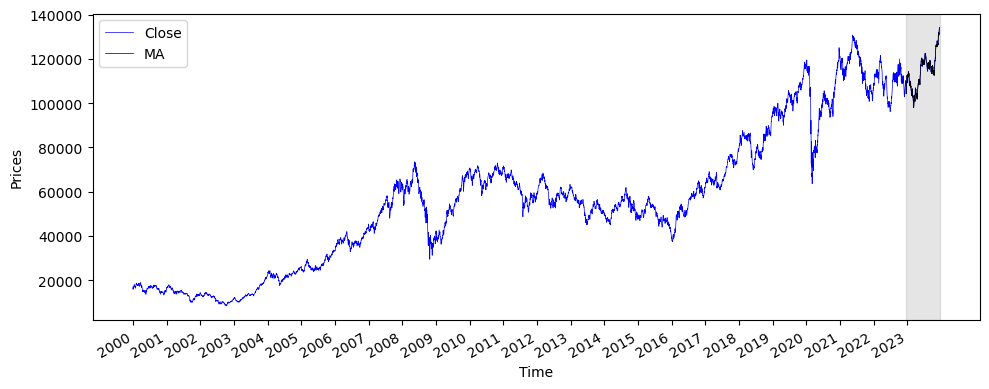

In [40]:
#===============================================================================================================================
# MA: PRICE - PLOT
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df['Close'], 'b-', label='Close', lw=0.5)    
#ax.plot(df.loc[testini+1:,'pred_Last'], 'r-' , label='Last', lw=0.5)
#ax.plot(df.loc[testini+1:,'pred_Mean'], 'm-.', label='Mean', lw=0.5)
ax.plot(df.loc[testini+1:,'pred_MA']  , 'k-' , label='MA'   , lw=0.5)   
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Prices')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
#ax.set_xlim(testini, totallen)
plt.xticks(np.arange(0, totallen, testlen), np.arange(2000, 2024, 1))
fig.autofmt_xdate()
plt.tight_layout()

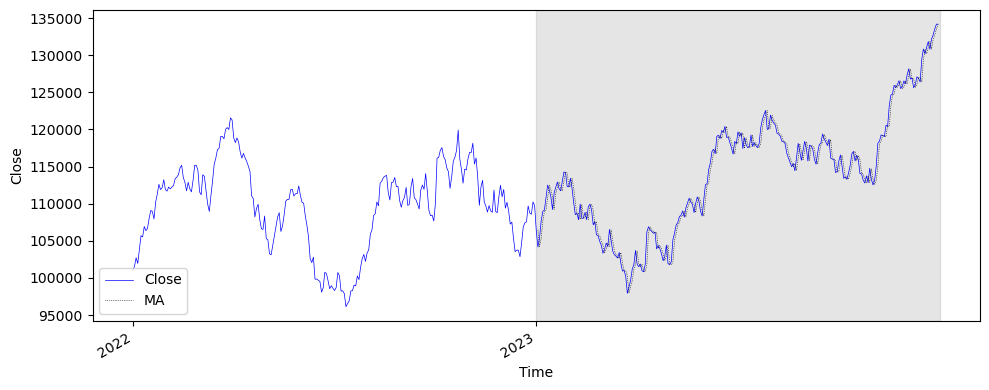

In [41]:
#===============================================================================================================================
# MA: PRICE - PLOT (zoom)
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df.loc[testini-testlen:,'Close'], 'b-' , label='Close', lw=0.5)    
#ax.plot(df.loc[testini+1:,'pred_Last']  , 'r-' , label='Last' , lw=0.5)
#ax.plot(df.loc[testini+1:,'pred_Mean']  , 'y-.', label='Mean' , lw=0.5)
ax.plot(df.loc[testini+1:,'pred_MA']    , 'k:' , label='MA'   , lw=0.5)   

ax.legend(loc=3)
ax.set_xlabel('Time')
ax.set_ylabel('Close')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
#ax.set_xlim(testini, totallen)
plt.xticks([testini-testlen, testini],           ['2022'          , '2023'])
fig.autofmt_xdate()
plt.tight_layout()

In [42]:
#===============================================================================================================================
# MA: PRICE - FILES
#===============================================================================================================================
df.loc[testini:,['Date','pred_Last']].to_csv('Data/Output/Rolling-Ln-Daily-Last.csv')
df.loc[testini:,['Date','pred_MA'  ]].to_csv('Data/Output/Rolling-Ln-Daily-MA.csv'  )
#df.loc[testini:,['Date','pred_MA'  ]].to_excel('Data/Output/Rolling-Ln-Daily-MA.xlsx')

In [43]:
################################################################################################################################
#
# AUTOREGRESSIVE (AR)
#
################################################################################################################################

In [44]:
#===============================================================================================================================
# AR
#
# LOG:      ADF Test + ACF Coefficients slowly decaying => AUTOCORRELATION present => NON-STATIONARY
# LOG-DIFF: ADF Test + ACF Almost no Autocorrelation => STATIONARY  => RANDOM WALK
#           ACF Coefficients don't become abruptly non-significant  => No MOVING AVERAGE
#           PACF Coefficients don't become abruptly non-significant => No AUTOREGRESSIVE
#===============================================================================================================================

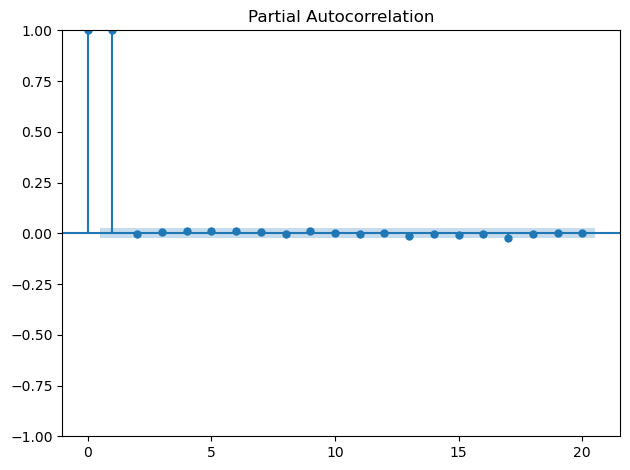

In [45]:
#===============================================================================================================================
# AR: LOG - PACF - AR(p) order
#===============================================================================================================================
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(dfln['CloseLn'], lags=20)
plt.tight_layout()

#-------------------------------------------------------------------------------------------------------------------------------
# PACF - order 1 AR(1)
#-------------------------------------------------------------------------------------------------------------------------------
# ****** AR(1) process ******
#-------------------------------------------------------------------------------------------------------------------------------

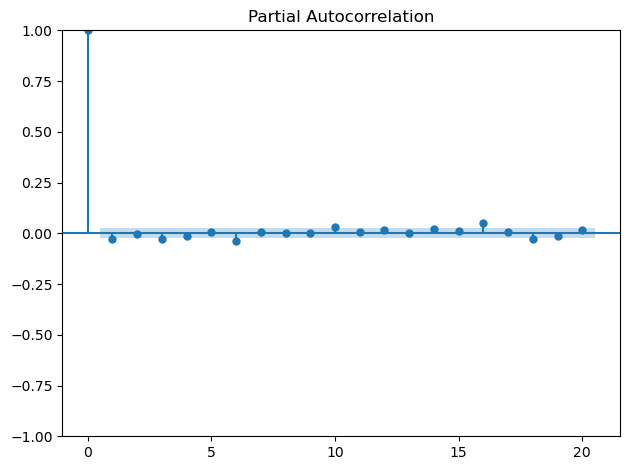

In [46]:
#===============================================================================================================================
# AR: LOG-RET - PACF - AR(p) order
#===============================================================================================================================
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(dfln['CloseLnDiff'], lags=20)
plt.tight_layout()

#-------------------------------------------------------------------------------------------------------------------------------
# PACF - NO AUTOCORRELATION
#-------------------------------------------------------------------------------------------------------------------------------
# ****** AR(0) process ******
#-------------------------------------------------------------------------------------------------------------------------------

#===============================================================================================================================
# AR: LOG-RET - ADF Test + PACF Plot
#===============================================================================================================================
#-------------------------------------------------------------------------------------------------------------------------------
# ****** RANDOM WALK ******
#-------------------------------------------------------------------------------------------------------------------------------

In [47]:
#===============================================================================================================================
# AR: LOG-RET - FORECAST
#===============================================================================================================================
pred_ARLnDiff = rolling_forecast(dfln['CloseLnDiff'], testini, HORIZON, WINDOW, 'AR', (1,0,0))

                               SARIMAX Results                                
Dep. Variable:            CloseLnDiff   No. Observations:                 5942
Model:               SARIMAX(1, 0, 0)   Log Likelihood               15586.545
Date:                Mon, 02 Dec 2024   AIC                         -31169.089
Time:                        15:15:32   BIC                         -31155.710
Sample:                             0   HQIC                        -31164.441
                               - 5942                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0277      0.007     -4.098      0.000      -0.041      -0.014
sigma2         0.0003   2.79e-06    110.736      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [48]:
#===============================================================================================================================
# AR: LOG-RET - STORE PRED, SAVE EXCEL
#===============================================================================================================================
testln.loc[testini:,'pred_ARLnDiff'] = 0
testln.loc[testini:,'pred_ARLnDiff'] = pred_ARLnDiff
testln.loc[testini:,'pred_ARLnDiff'].to_excel('Data/Output/Rolling-Ln-Daily-ARLnDiff.xlsx')

In [49]:
#===============================================================================================================================
# AR: LOG-RET - PERFORMANCE
#===============================================================================================================================
mse_MA     = mean_squared_error(dfln.loc[testini:,'CloseLnDiff'], testln.loc[testini:,'pred_MALnDiff'  ])
mse_AR     = mean_squared_error(dfln.loc[testini:,'CloseLnDiff'], testln.loc[testini:,'pred_ARLnDiff'  ])

data_metrics = [['MA'    , "{:,}".format(round(mse_MA  ,6))  , "{:,}".format(round(sqrt(mse_MA)  ,6))] ,
                ['AR'    , "{:,}".format(round(mse_AR  ,6))  , "{:,}".format(round(sqrt(mse_AR)  ,6))] ]
 
df_metrics = pd.DataFrame(data_metrics, columns=['Log Diff', 'MSE', 'RMSE'])
df_metrics

,Log Diff,MSE,RMSE
0,MA,0.000118,0.010858
1,AR,0.000118,0.010859


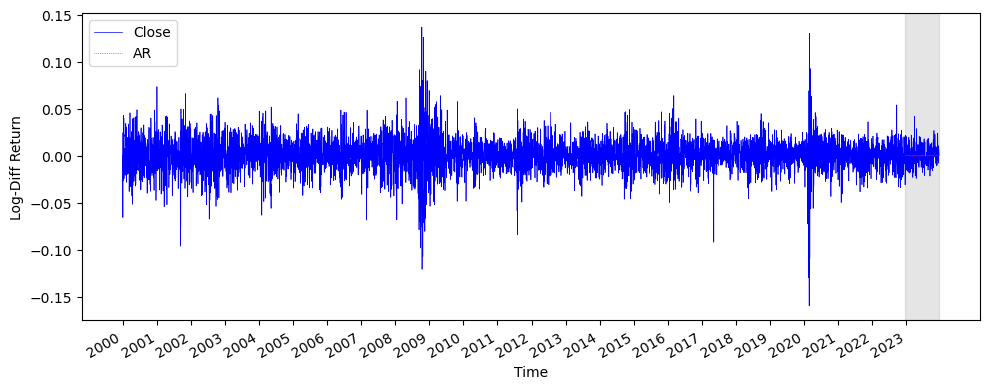

In [50]:
#===============================================================================================================================
# AR: LOG-RET - PLOT
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(dfln['CloseLnDiff']    , 'b-', label='Close', lw=0.5)    
#ax.plot(testln['pred_MALnDiff'], 'g-', label='MA'   , lw=0.5)   
ax.plot(testln['pred_ARLnDiff'], 'r:', label='AR'   , lw=0.5)   
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Log-Diff Return')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
plt.xticks(np.arange(0, totallen, testlen), np.arange(2000, 2024, 1))
fig.autofmt_xdate()
plt.tight_layout()

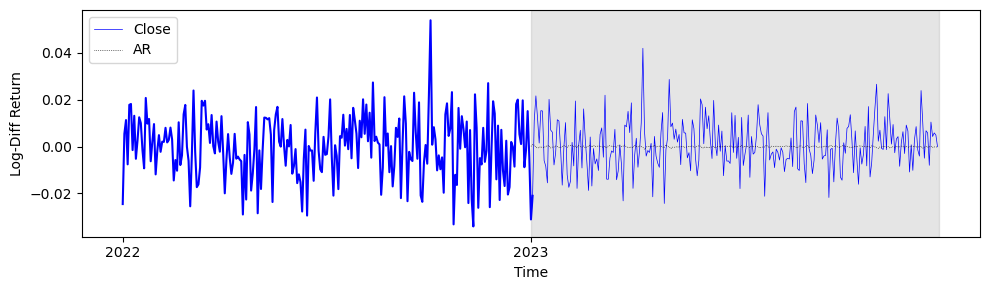

In [51]:
#===============================================================================================================================
# AR: LOG-RET - PLOT (zoom)
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(dfln.loc[testini-testlen:testini+1,'CloseLnDiff'], 'b-') 
ax.plot(dfln.loc[testini:totallen,'CloseLnDiff']         , 'b-' , label='Close', lw=0.5)
#ax.plot(testln.loc[testini:totallen,'pred_MALnDiff']     , 'm-.', label='MA'   , lw=0.5)
ax.plot(testln.loc[testini:totallen,'pred_ARLnDiff']     , 'k:' , label='AR'   , lw=0.5)
ax.axvspan(testini,testini+testlen, color='#808080', alpha=0.2)
ax.legend(loc=2)
plt.xticks([testini-testlen, testini],           ['2022'          , '2023'])
ax.set_xlabel('Time')
ax.set_ylabel('Log-Diff Return')
plt.tight_layout()

In [52]:
#===============================================================================================================================
# AR: LOG - RECOVER
#===============================================================================================================================
dfln['pred_ARLn'] = 0.0
dfln.loc[testini:,'pred_ARLn'] = dfln.shift(periods=1).loc[testini:, 'CloseLn'] + testln.loc[testini:,'pred_ARLnDiff']
dfln.loc[testini:,'pred_ARLn'].to_excel('Data/Output/Rolling-Ln-Daily-ARLn.xlsx')
dfln[testini-1:]

,Date,Close,CloseLn,CloseLnDiff,pred_LastLn,pred_MeanLn,pred_MALn,pred_ARLn
5694,2022-12-29,109734.60,11.605820,-0.004565,0.000000,0.000000,0.000000,0.000000
5695,2023-01-02,106376.02,11.574735,-0.031085,11.605820,10.729549,11.605938,11.605954
5696,2023-01-03,104165.74,11.553739,-0.020997,11.574735,10.729697,11.575626,11.575645
5697,2023-01-04,105334.46,11.564896,0.011157,11.553739,10.729842,11.554354,11.554345
5698,2023-01-05,107641.32,11.586560,0.021664,11.564896,10.729988,11.564598,11.564572
...,...,...,...,...,...,...,...,...
5938,2023-12-21,132182.01,11.791935,0.010479,11.781457,10.766810,11.781667,11.781677
5939,2023-12-22,132752.93,11.796245,0.004310,11.791935,10.766983,11.791657,11.791645
5940,2023-12-26,133532.92,11.802103,0.005858,11.796245,10.767156,11.796121,11.796126
5941,2023-12-27,134193.72,11.807040,0.004936,11.802103,10.767330,11.801942,11.801941


In [53]:
#===============================================================================================================================
# AR: LOG - PERFORMANCE
#===============================================================================================================================
mse_Last   = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_LastLn'])
mse_Mean   = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_MeanLn'])
mse_MA     = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_MALn'  ])
mse_AR     = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_ARLn'  ])

data_metrics = [['Last'  , "{:,}".format(round(mse_Last,6 ))  , "{:,}".format(round(sqrt(mse_Last),6))] ,
                ['Mean'  , "{:,}".format(round(mse_Mean,6 ))  , "{:,}".format(round(sqrt(mse_Mean),6))] ,
                ['MA'    , "{:,}".format(round(mse_MA  ,6 ))  , "{:,}".format(round(sqrt(mse_MA)  ,6))] ,
                ['AR'    , "{:,}".format(round(mse_AR  ,6 ))  , "{:,}".format(round(sqrt(mse_AR)  ,6))] ]

df_metrics = pd.DataFrame(data_metrics, columns=['Log', 'MSE', 'RMSE'])
df_metrics

,Log,MSE,RMSE
0,Last,0.000117,0.010831
1,Mean,0.805004,0.89722
2,MA,0.000118,0.010858
3,AR,0.000118,0.010859


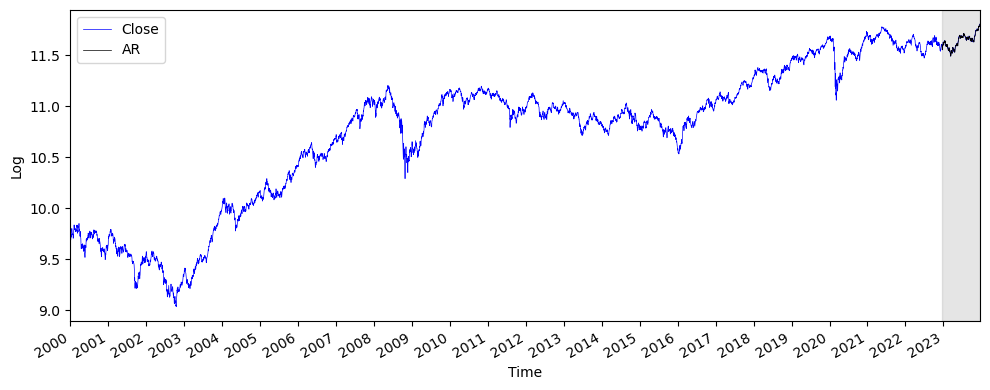

In [54]:
#===============================================================================================================================
# AR: LOG - PLOT
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(dfln['CloseLn']                 , 'b-', label='Close', lw=0.5)    
#ax.plot(dfln.loc[testini:,'pred_LastLn'], 'r-' , label='Last')
#ax.plot(dfln.loc[testini:,'pred_MeanLn'], 'm-.', label='Mean')
#ax.plot(dfln.loc[testini:,'pred_MALn']  , 'y-' , label='MA')   
ax.plot(dfln.loc[testini:,'pred_ARLn']  , 'k-' , label='AR'  , lw=0.5)   
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Log')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax.set_xlim(testini, totallen)
plt.xticks(np.arange(0, totallen, testlen), np.arange(2000, 2024, 1))
fig.autofmt_xdate()
plt.tight_layout()

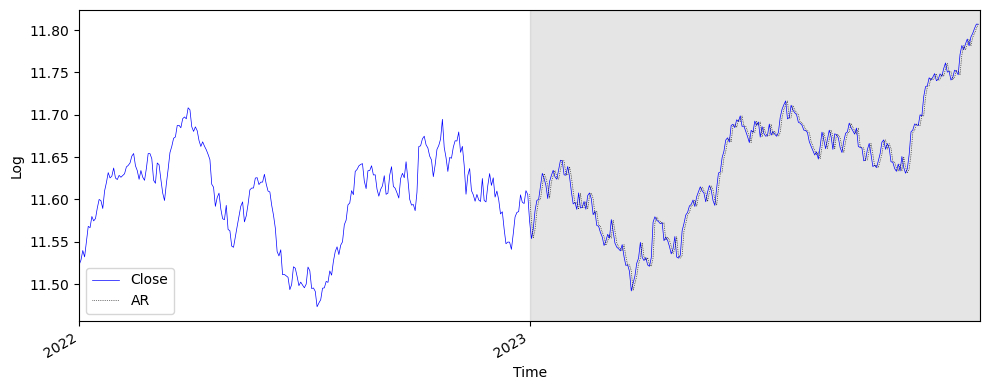

In [55]:
#===============================================================================================================================
# AR: LOG - PLOT (zoom)
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(dfln.loc[testini-testlen:,'CloseLn'], 'b-' , label='Close' , lw=0.5)
#ax.plot(dfln.loc[testini:,'pred_LastLn']    , 'r-' , label='Last')
#ax.plot(dfln.loc[testini:,'pred_MeanLn']    , 'm-.', label='Mean')
#ax.plot(dfln.loc[testini:,'pred_MALn']      , 'y:' , label='MA')
ax.plot(dfln.loc[testini:,'pred_ARLn']      , 'k:' , label='AR'    , lw=0.5)

ax.legend(loc=3)
ax.set_xlabel('Time')
ax.set_ylabel('Log')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax.set_xlim(testini, totallen)
plt.xticks([testini-testlen, testini],           ['2022'          , '2023'])
fig.autofmt_xdate()
plt.tight_layout()

In [56]:
#===============================================================================================================================
# AR: PRICE - RECOVER
#===============================================================================================================================
df['pred_AR'] = 0.0
df.loc[testini:,'pred_AR']= np.round(np.exp(dfln.loc[testini:,'pred_ARLn']),2)

df[testini-1:]

,Date,Close,pred_Last,pred_Mean,pred_MA,pred_AR
5694,2022-12-29,109734.60,0.00,0.00,0.00,0.00
5695,2023-01-02,106376.02,109734.60,55564.15,109747.57,109749.29
5696,2023-01-03,104165.74,106376.02,55573.07,106470.77,106472.78
5697,2023-01-04,105334.46,104165.74,55581.60,104229.91,104228.91
5698,2023-01-05,107641.32,105334.46,55590.33,105303.06,105300.39
...,...,...,...,...,...,...
5938,2023-12-21,132182.01,130804.17,57947.47,130831.75,130833.02
5939,2023-12-22,132752.93,132182.01,57959.97,132145.31,132143.63
5940,2023-12-26,133532.92,132752.93,57972.56,132736.48,132737.09
5941,2023-12-27,134193.72,133532.92,57985.28,133511.35,133511.27


In [57]:
#===============================================================================================================================
# AR: PRICE - PERFORMANCE
#===============================================================================================================================
mse_Last = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_Last'])
mse_Mean = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_Mean'])
mse_MA   = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_MA'  ])
mse_AR   = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_AR'  ])

data_metrics = [['Last'  , "{:,}".format(round(mse_Last,))  , "{:,}".format(round(sqrt(mse_Last),1))] ,
                ['MA'    , "{:,}".format(round(mse_MA,  ))  , "{:,}".format(round(sqrt(mse_MA  ),1))] ,
                ['AR'    , "{:,}".format(round(mse_AR,  ))  , "{:,}".format(round(sqrt(mse_AR  ),1))] ]

df_metrics   = pd.DataFrame(data_metrics, columns=['Price', 'MSE', 'RMSE'])
df_metrics

,Price,MSE,RMSE
0,Last,"1,476,001","1,214.9"
1,MA,"1,482,822","1,217.7"
2,AR,"1,483,149","1,217.8"


In [58]:
################################################################################################################################
#
# ARMA
#
################################################################################################################################

In [59]:
#===============================================================================================================================
# ARMA: OPTIMIZE Function - AIC (Akaike Information Criterion)
#===============================================================================================================================
def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
             continue
        
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [60]:
#===============================================================================================================================
# ARMA: TRAIN SET
#===============================================================================================================================
train = df.Close[:trainfin+1]
trainLn = dfln.CloseLn[:trainfin+1]
trainLnDiff = dfln.CloseLnDiff[:trainfin+1]
trainLnDiff

0       0.000000
1      -0.065879
2       0.024561
3      -0.008547
4       0.012479
          ...   
5690    0.019757
5691   -0.008788
5692   -0.001468
5693    0.015159
5694   -0.004565
Name: CloseLnDiff, Length: 5695, dtype: float64

In [61]:
#===============================================================================================================================
# ARMA: PARAMETERS ps, qs
#===============================================================================================================================
from itertools import product
ps = range(0, 4, 1)    
qs = range(0, 4, 1)     

order_list = list(product(ps, qs))
len(order_list)

16

In [62]:
#===============================================================================================================================
# ARMA: Optimize_ARMA
#===============================================================================================================================
result_df = optimize_ARMA(trainLnDiff, order_list) 
result_df

C:\Users\55119\AppData\Local\Temp\ipykernel_15036\3737658289.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/16 [00:00<?, ?it/s]

C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,"(p,q)",AIC
0,"(0, 3)",-29723.738263
1,"(3, 0)",-29723.150364
2,"(0, 1)",-29723.100853
3,"(1, 0)",-29723.084572
4,"(3, 3)",-29722.980629
5,"(3, 1)",-29721.217607
6,"(1, 1)",-29721.206665
7,"(0, 2)",-29721.141473
8,"(2, 0)",-29721.102204
9,"(1, 3)",-29720.724943


In [63]:
#===============================================================================================================================
# ARMA: LOG-RET - FORECAST
#===============================================================================================================================
pred_ARMALnDiff = rolling_forecast(dfln['CloseLnDiff'], testini, HORIZON, WINDOW, 'ARMA',(1,0,0))

                               SARIMAX Results                                
Dep. Variable:            CloseLnDiff   No. Observations:                 5942
Model:               SARIMAX(1, 0, 0)   Log Likelihood               15586.545
Date:                Mon, 02 Dec 2024   AIC                         -31169.089
Time:                        15:17:26   BIC                         -31155.710
Sample:                             0   HQIC                        -31164.441
                               - 5942                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0277      0.007     -4.098      0.000      -0.041      -0.014
sigma2         0.0003   2.79e-06    110.736      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [64]:
#===============================================================================================================================
# ARMA: LOG-RET - STORE PRED, SAVE EXCEL
#===============================================================================================================================
testln.loc[testini:,'pred_ARMALnDiff'] = 0
testln.loc[testini:,'pred_ARMALnDiff'] = pred_ARMALnDiff
testln.loc[testini:,'pred_ARMALnDiff'].to_excel('Data/Output/Rolling-Ln-Daily-ARMALnDiff.xlsx')

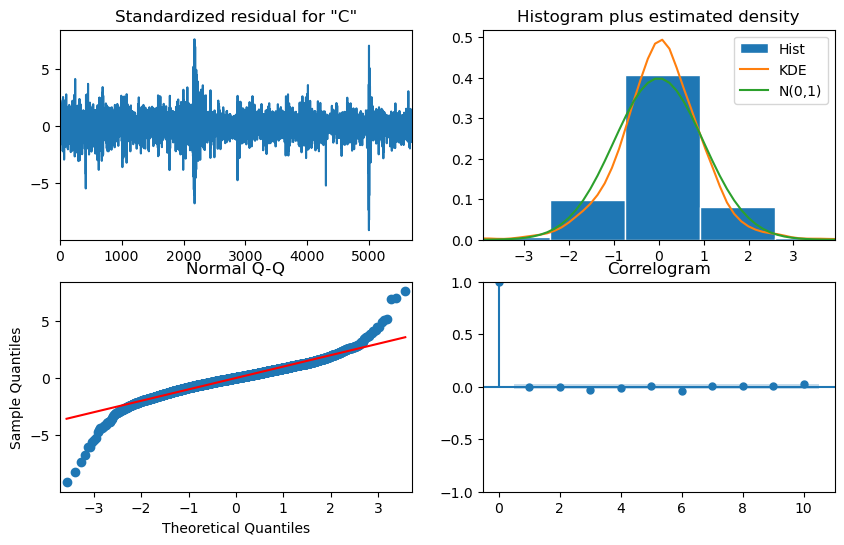

In [65]:
#===============================================================================================================================
# ARMA: LOG-RET - DIAGNOSTICS
#===============================================================================================================================
model = SARIMAX(trainLnDiff, order=(0,0,1), simple_differencing=False)
model_fit = model.fit(disp=False)
model_fit.plot_diagnostics(figsize=(10,6))
residuals = model_fit.resid 

#-------------------------------------------------------------------------------------------------------------------------------
#
# Residuals: No Trend, but Variance is not constant (discrepancy to white noise).
# Residuals: Distribution fairly close to a Normal distribution.
# Q-Q plot: Line fairly straight => Residuals’ distribution close to a Normal distribution.
# Correlogram: No significant Coefficients after lag 0 => White Noise.
#
#-------------------------------------------------------------------------------------------------------------------------------

In [66]:
#===============================================================================================================================
# ARMA: LOG-RET - RESIDUALS - LJUNG-BOX test
#===============================================================================================================================
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm

sm.stats.acorr_ljungbox(residuals, lags=[11], return_df=True)

#-------------------------------------------------------------------------------------------------------------------------------
# LJUNG-BOX test: pvalue > 0.05 => Residuals NOT CORRELATED
#-------------------------------------------------------------------------------------------------------------------------------
# ***** WHITE NOISE => Model can be used to FORECAST *****
#-------------------------------------------------------------------------------------------------------------------------------

,lb_stat,lb_pvalue
11,20.325621,0.04107


In [67]:
#===============================================================================================================================
# ARMA: LOG-RET - PERFORMANCE
#===============================================================================================================================
mse_MA     = mean_squared_error(dfln.loc[testini:,'CloseLnDiff'], testln.loc[testini:,'pred_MALnDiff'  ])
mse_AR     = mean_squared_error(dfln.loc[testini:,'CloseLnDiff'], testln.loc[testini:,'pred_ARLnDiff'  ])
mse_ARMA   = mean_squared_error(dfln.loc[testini:,'CloseLnDiff'], testln.loc[testini:,'pred_ARMALnDiff'])

data_metrics = [['MA'    , "{:,}".format(round(mse_MA  ,6))  , "{:,}".format(round(sqrt(mse_MA)  ,6))] ,
                ['AR'    , "{:,}".format(round(mse_AR  ,6))  , "{:,}".format(round(sqrt(mse_AR)  ,6))] ,
                ['ARMA'  , "{:,}".format(round(mse_ARMA,6))  , "{:,}".format(round(sqrt(mse_ARMA),6))] ]
 
df_metrics = pd.DataFrame(data_metrics, columns=['Log Diff', 'MSE', 'RMSE'])
df_metrics

,Log Diff,MSE,RMSE
0,MA,0.000118,0.010858
1,AR,0.000118,0.010859
2,ARMA,0.000118,0.010859


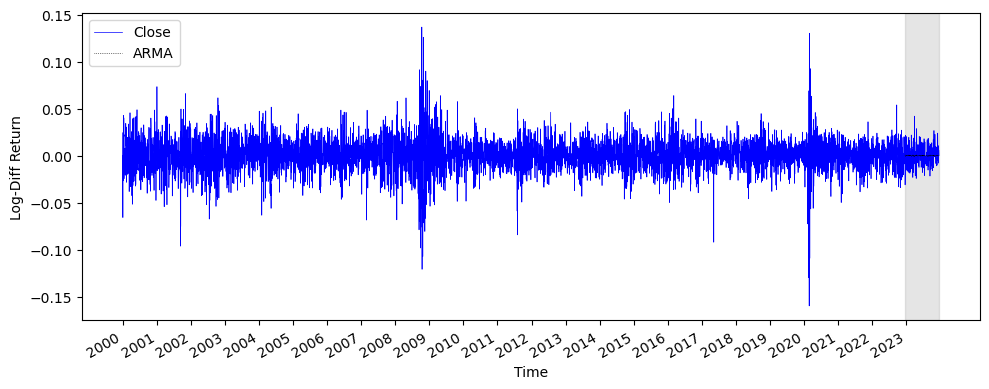

In [68]:
#===============================================================================================================================
# ARMA: LOG-RET - PLOT
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(dfln['CloseLnDiff']      , 'b-' , label='Close', lw=0.5)
#ax.plot(testln['pred_MALnDiff']  , 'g-' , label='MA')
#ax.plot(testln['pred_ARLnDiff']  , 'y-.', label='AR')
ax.plot(testln['pred_ARMALnDiff'], 'k:' , label='ARMA' , lw=0.5)
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Log-Diff Return')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
plt.xticks(np.arange(0, totallen, testlen), np.arange(2000, 2024, 1))
fig.autofmt_xdate()
plt.tight_layout()

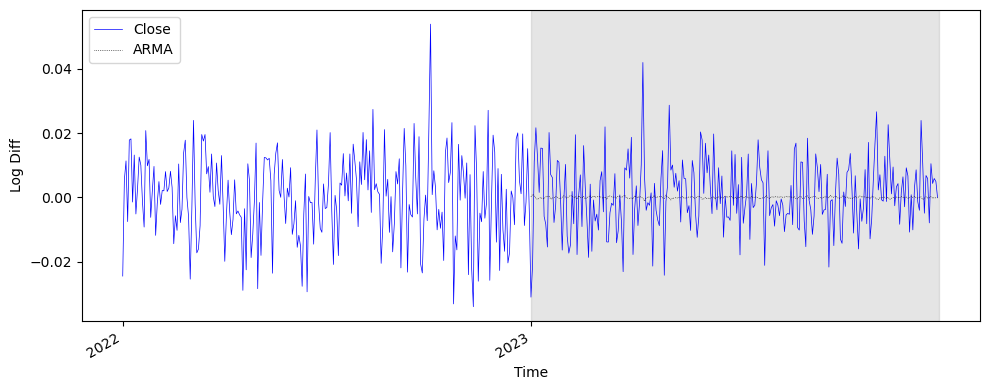

In [69]:
#===============================================================================================================================
# ARMA: LOG-RET - PLOT (zoom)
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(dfln.loc[testini-testlen:,'CloseLnDiff'], 'b-' , label='Close', lw=0.5)
#ax.plot(testln.loc[-testlen:,'pred_MALnDiff']   , 'g-' , label='MA')
#ax.plot(testln.loc[-testlen:,'pred_ARLnDiff']   , 'y-.', label='AR')
ax.plot(testln.loc[-testlen:,'pred_ARMALnDiff'] , 'k:' , label='ARMA' , lw=0.5)
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Log Diff')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
plt.xticks(np.arange(testini-testlen, totallen, testlen), [2022, 2023])
fig.autofmt_xdate()
plt.tight_layout()

In [70]:
#===============================================================================================================================
# ARMA: LOG - RECOVER
#===============================================================================================================================
dfln['pred_ARMALn'] = 0.0
dfln.loc[testini:,'pred_ARMALn'] = dfln.shift(periods=1).loc[testini:, 'CloseLn'] + testln.loc[testini:,'pred_ARMALnDiff']
dfln[testini-1:]

,Date,Close,CloseLn,CloseLnDiff,pred_LastLn,pred_MeanLn,pred_MALn,pred_ARLn,pred_ARMALn
5694,2022-12-29,109734.60,11.605820,-0.004565,0.000000,0.000000,0.000000,0.000000,0.000000
5695,2023-01-02,106376.02,11.574735,-0.031085,11.605820,10.729549,11.605938,11.605954,11.605954
5696,2023-01-03,104165.74,11.553739,-0.020997,11.574735,10.729697,11.575626,11.575645,11.575645
5697,2023-01-04,105334.46,11.564896,0.011157,11.553739,10.729842,11.554354,11.554345,11.554345
5698,2023-01-05,107641.32,11.586560,0.021664,11.564896,10.729988,11.564598,11.564572,11.564572
...,...,...,...,...,...,...,...,...,...
5938,2023-12-21,132182.01,11.791935,0.010479,11.781457,10.766810,11.781667,11.781677,11.781677
5939,2023-12-22,132752.93,11.796245,0.004310,11.791935,10.766983,11.791657,11.791645,11.791645
5940,2023-12-26,133532.92,11.802103,0.005858,11.796245,10.767156,11.796121,11.796126,11.796126
5941,2023-12-27,134193.72,11.807040,0.004936,11.802103,10.767330,11.801942,11.801941,11.801941


In [71]:
#===============================================================================================================================
# ARMA: LOG - PERFORMANCE
#===============================================================================================================================
mse_Last   = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_LastLn'])
mse_Mean   = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_MeanLn'])
mse_MA     = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_MALn'  ])
mse_AR     = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_ARLn'  ])
mse_ARMA   = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_ARMALn'])

data_metrics = [['Last'  , "{:,}".format(round(mse_Last,8 ))  , "{:,}".format(round(sqrt(mse_Last),6))] ,
                ['Mean'  , "{:,}".format(round(mse_Mean,8))  , "{:,}".format(round(sqrt(mse_Mean) ,6))] ,
                ['MA'    , "{:,}".format(round(mse_MA  ,8 ))  , "{:,}".format(round(sqrt(mse_MA)  ,6))] ,
                ['AR'    , "{:,}".format(round(mse_AR  ,8 ))  , "{:,}".format(round(sqrt(mse_AR)  ,6))] ,
                ['ARMA'  , "{:,}".format(round(mse_ARMA,8 ))  , "{:,}".format(round(sqrt(mse_ARMA),6))] ]

df_metrics = pd.DataFrame(data_metrics, columns=['Log', 'MSE', 'RMSE'])
df_metrics

,Log,MSE,RMSE
0,Last,0.00011731,0.010831
1,Mean,0.8050039,0.89722
2,MA,0.00011789,0.010858
3,AR,0.00011792,0.010859
4,ARMA,0.00011792,0.010859


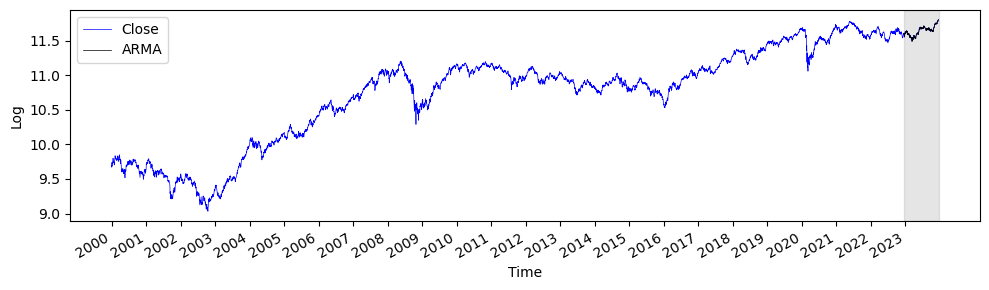

In [72]:
#===============================================================================================================================
# ARMA: LOG - Plot
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(dfln['CloseLn'], 'b-', label='Close', lw=0.5)
#ax.plot(dfln.loc[testini:,'pred_LastLn'], 'r-' , label='Last')
#ax.plot(dfln.loc[testini:,'pred_MeanLn'], 'm-.', label='Mean')
#ax.plot(dfln.loc[testini:,'pred_MALn']  , 'y-' , label='MA')   
#ax.plot(dfln.loc[testini:,'pred_ARLn']  , 'g-.', label='AR')   
ax.plot(dfln.loc[testini:,'pred_ARMALn'], 'k-' , label='ARMA', lw=0.5)
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Log')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
#ax.set_xlim(testini, totallen)
plt.xticks(np.arange(0, totallen, testlen), np.arange(2000, 2024, 1))
fig.autofmt_xdate()
plt.tight_layout()

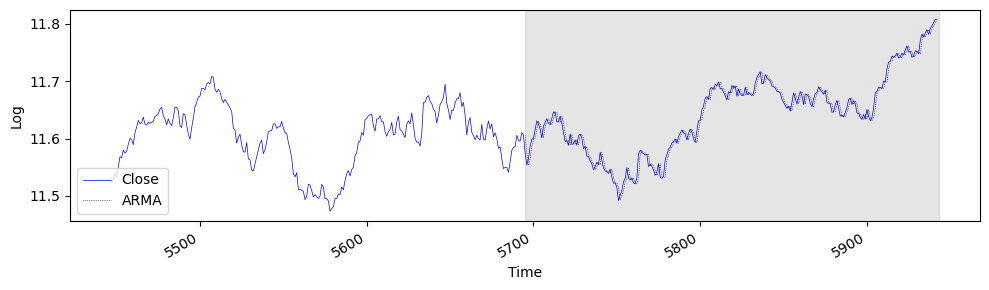

In [73]:
#===============================================================================================================================
# ARMA: LOG - Plot (zoom)
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(dfln.loc[testini-testlen:,'CloseLn']   , 'b-', label='Close', lw=0.5)
#ax.plot(dfln.loc[testini:,'pred_LastLn'] , 'r-' , label='Last')
#ax.plot(dfln.loc[testini:,'pred_MeanLn'] , 'm-.', label='Mean')
#ax.plot(dfln.loc[testini:,'pred_MALn']   , 'y:' , label='MA')
#ax.plot(dfln.loc[testini:,'pred_ARLn']   , 'g:' , label='AR')
ax.plot(dfln.loc[testini:,'pred_ARMALn'] , 'k:' , label='ARMA', lw=0.5)

ax.legend(loc=3)
ax.set_xlabel('Time')
ax.set_ylabel('Log')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
#ax.set_xlim(testini, totallen)
#plt.xticks([testini-totallen, totallen],           ['2022'          , '2023'])
fig.autofmt_xdate()
plt.tight_layout()

In [74]:
#===============================================================================================================================
# ARMA: PRICE - RECOVER
#===============================================================================================================================
df['pred_ARMA'] = 0.0
df.loc[testini:,'pred_ARMA']= np.round(np.exp(dfln.loc[testini:,'pred_ARMALn']),2)
df[testini-1:]

,Date,Close,pred_Last,pred_Mean,pred_MA,pred_AR,pred_ARMA
5694,2022-12-29,109734.60,0.00,0.00,0.00,0.00,0.00
5695,2023-01-02,106376.02,109734.60,55564.15,109747.57,109749.29,109749.29
5696,2023-01-03,104165.74,106376.02,55573.07,106470.77,106472.78,106472.78
5697,2023-01-04,105334.46,104165.74,55581.60,104229.91,104228.91,104228.91
5698,2023-01-05,107641.32,105334.46,55590.33,105303.06,105300.39,105300.39
...,...,...,...,...,...,...,...
5938,2023-12-21,132182.01,130804.17,57947.47,130831.75,130833.02,130833.02
5939,2023-12-22,132752.93,132182.01,57959.97,132145.31,132143.63,132143.63
5940,2023-12-26,133532.92,132752.93,57972.56,132736.48,132737.09,132737.09
5941,2023-12-27,134193.72,133532.92,57985.28,133511.35,133511.27,133511.27


In [75]:
#===============================================================================================================================
# ARMA: PRICE - PERFORMANCE
#===============================================================================================================================
mse_Last = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_Last'])
mse_Mean = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_Mean'])
mse_MA   = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_MA'  ])
mse_AR   = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_AR'  ])
mse_ARMA = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_ARMA'])

data_metrics = [['Last'  , "{:,}".format(round(mse_Last,))  , "{:,}".format(round(sqrt(mse_Last),1))] ,
                ['MA'    , "{:,}".format(round(mse_MA,  ))  , "{:,}".format(round(sqrt(mse_MA)  ,1))] ,
                ['AR'    , "{:,}".format(round(mse_AR,  ))  , "{:,}".format(round(sqrt(mse_AR)  ,1))] ,
                ['ARMA'  , "{:,}".format(round(mse_ARMA,))  , "{:,}".format(round(sqrt(mse_ARMA),1))] ]
 
df_metrics = pd.DataFrame(data_metrics, columns=['Model', 'MSE', 'RMSE'])
df_metrics

,Model,MSE,RMSE
0,Last,"1,476,001","1,214.9"
1,MA,"1,482,822","1,217.7"
2,AR,"1,483,149","1,217.8"
3,ARMA,"1,483,149","1,217.8"


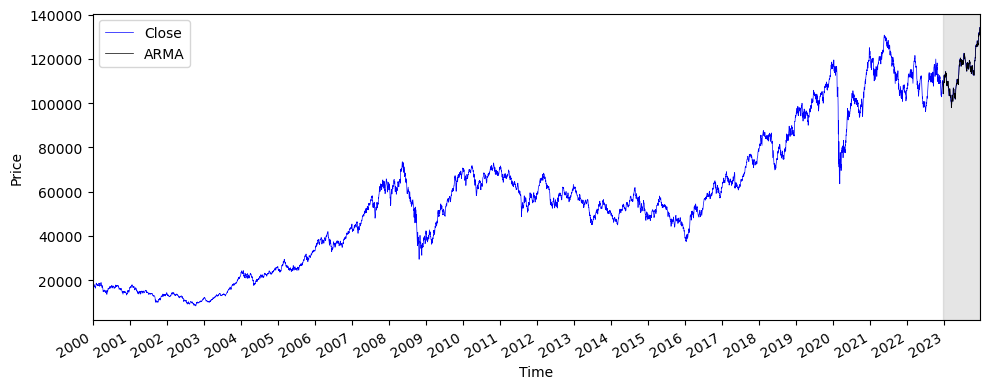

In [76]:
#===============================================================================================================================
# ARMA: PRICE - PLOT
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df['Close'], 'b-', label='Close', lw=0.5)    
#ax.plot(df.loc[testini:,'pred_Last'], 'r-' , label='Last', lw=0.5)
#ax.plot(df.loc[testini:,'pred_Mean'], 'm-.', label='Mean')
#ax.plot(df.loc[testini:,'pred_MA']  , 'y-' , label='MA')   
#ax.plot(df.loc[testini:,'pred_AR']  , 'g-.', label='AR')   
ax.plot(df.loc[testini:,'pred_ARMA'], 'k-' , label='ARMA', lw=0.5)   
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax.set_xlim(testini, totallen)
plt.xticks(np.arange(0, totallen, testlen), np.arange(2000, 2024, 1))
fig.autofmt_xdate()
plt.tight_layout()

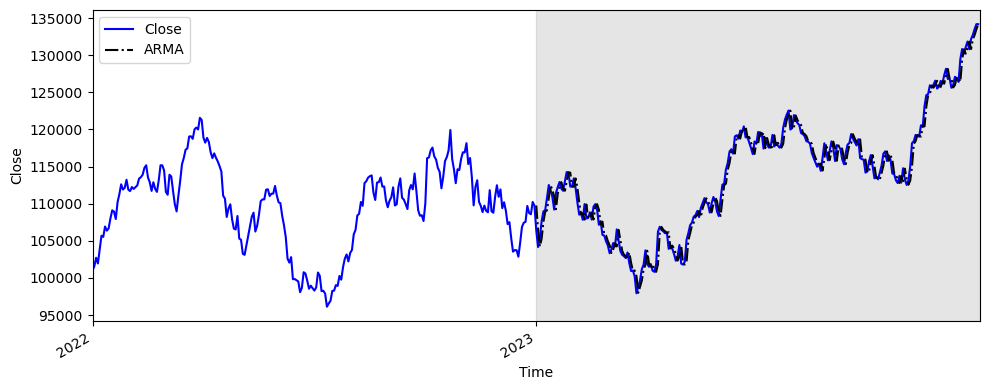

In [77]:
#===============================================================================================================================
# ARMA: PRICE - PLOT (zoom)
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df.loc[testini-testlen:,'Close']  , 'b-' , label='Close')
#ax.plot(df.loc[testini:,'pred_Last'], 'r-' , label='Last')
#ax.plot(df.loc[testini:,'pred_Mean'], 'm-.', label='Mean')
#ax.plot(df.loc[testini:,'pred_MA']  , 'y:' , label='MA')
#ax.plot(df.loc[testini:,'pred_AR']  , 'g:' , label='AR')
ax.plot(df.loc[testini:,'pred_ARMA'], 'k-.', label='ARMA')

ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Close')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax.set_xlim(testini-testlen, totallen)
plt.xticks([ testini-testlen, testini],           ['2022'          , '2023'])
fig.autofmt_xdate()
plt.tight_layout()

In [78]:
################################################################################################################################
#
# ROLLING ARIMA
#
################################################################################################################################

In [79]:
#===============================================================================================================================
# ROLLING ARIMA: LIBRARIES
#===============================================================================================================================
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot

#===============================================================================================================================
# ROLLING ARIMA: LOG - LISTS
#===============================================================================================================================
CloseList = dfln['CloseLn'].values
CloseTrain, CloseTest = CloseList[0:trainlen], CloseList[testini:]
HistTrain = [x for x in CloseTrain]
PredTest = list()

In [80]:
#===============================================================================================================================
# ROLLING ARIMA: LOG - AUTOARIMA - AIC (Akaike)
#===============================================================================================================================
import pandas as pd
import pmdarima as pmd

results = pmd.auto_arima(dfln['CloseLn'],
                         start_p=0,  # initial guess for AR(p)
                         start_d=0,  # initial guess for I(d)
                         start_q=0,  # initial guess for MA(q)
                         max_p=4,   # max guess for AR(p)
                         max_d=1,    # max guess for I(d)
                         max_q=4,   # max guess for MA(q)
                         trend='c',
                         information_criterion='aic',
                         trace=True,
                         error_action='ignore'
                         )

#-------------------------------------------------------------------------------------------------------------------------------
# AIC
#-------------------------------------------------------------------------------------------------------------------------------
# Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
# Total fit time: 16.514 seconds
#-------------------------------------------------------------------------------------------------------------------------------

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-31166.880, Time=0.58 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-31169.576, Time=1.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-31169.602, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-31166.880, Time=0.71 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-31168.050, Time=2.95 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-31167.687, Time=2.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-31166.833, Time=4.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-31169.602, Time=0.72 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 13.055 seconds


In [81]:
#===============================================================================================================================
# ROLLING ARIMA: LOG - AUTOARIMA - BIC (Bayes)
#===============================================================================================================================
results = pmd.auto_arima(dfln['CloseLn'],
                         start_p=0,  # initial guess for AR(p)
                         start_d=0,  # initial guess for I(d)
                         start_q=0,  # initial guess for MA(q)
                         max_p=4,    # max guess for AR(p)
                         max_d=1,    # max guess for I(d)
                         max_q=4,    # max guess for MA(q)
                         trend='c',
                         information_criterion='bic',
                         trace=True,
                         error_action='ignore'
                         )

#-------------------------------------------------------------------------------------------------------------------------------
# BIC
#-------------------------------------------------------------------------------------------------------------------------------
# Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
# Total fit time: 3.963 seconds
#-------------------------------------------------------------------------------------------------------------------------------

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=-31153.500, Time=0.69 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=-31149.506, Time=1.32 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=-31149.532, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=-31153.500, Time=0.67 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=-31141.291, Time=2.30 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 5.571 seconds


In [82]:
#===============================================================================================================================
# ROLLING ARIMA: LOG - FORECAST
#===============================================================================================================================
for t in range(testlen):
    # AIC - AKAIKE
    ARIMA_ROLL_model = SARIMAX(HistTrain, order=(0,1,1), simple_differencing=False)
    # BIC - BAYES
    #ARIMA_ROLL_model = SARIMAX(HistTrain, order=(0,1,0), simple_differencing=False)

    ARIMA_ROLL_model_fit = ARIMA_ROLL_model.fit(disp=False)

    output = ARIMA_ROLL_model_fit.forecast()
    yhat = output[0]
    PredTest.append(yhat)
    yobs = CloseTest[t]
    HistTrain.append(yobs)
    print('t = %d, Estimation = %f, Observed = %f' % (t, yhat, yobs))
    dfln.loc[trainlen+t,'pred_ARIMARLn'] = yhat
    

t = 0, Estimation = 11.605938, Observed = 11.574735
t = 1, Estimation = 11.575623, Observed = 11.553739
t = 2, Estimation = 11.554352, Observed = 11.564896
t = 3, Estimation = 11.564599, Observed = 11.586560
t = 4, Estimation = 11.585944, Observed = 11.598770


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 5, Estimation = 11.598412, Observed = 11.600291
t = 6, Estimation = 11.600239, Observed = 11.615633


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 7, Estimation = 11.615204, Observed = 11.630860
t = 8, Estimation = 11.630426, Observed = 11.624916


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 9, Estimation = 11.625069, Observed = 11.616529
t = 10, Estimation = 11.616766, Observed = 11.601052
t = 11, Estimation = 11.601487, Observed = 11.621234


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 12, Estimation = 11.620684, Observed = 11.628291
t = 13, Estimation = 11.628080, Observed = 11.634452
t = 14, Estimation = 11.634275, Observed = 11.626617
t = 15, Estimation = 11.626830, Observed = 11.623906
t = 16, Estimation = 11.623987, Observed = 11.635392
t = 17, Estimation = 11.635075, Observed = 11.646320


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 18, Estimation = 11.646008, Observed = 11.645510
t = 19, Estimation = 11.645524, Observed = 11.629073
t = 20, Estimation = 11.629529, Observed = 11.628689
t = 21, Estimation = 11.628712, Observed = 11.638946
t = 22, Estimation = 11.638662, Observed = 11.626911
t = 23, Estimation = 11.627237, Observed = 11.609513


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 24, Estimation = 11.610004, Observed = 11.594722
t = 25, Estimation = 11.595142, Observed = 11.596546
t = 26, Estimation = 11.596507, Observed = 11.588309
t = 27, Estimation = 11.588534, Observed = 11.607795
t = 28, Estimation = 11.607263, Observed = 11.589961
t = 29, Estimation = 11.590442, Observed = 11.590611
t = 30, Estimation = 11.590606, Observed = 11.597602


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 31, Estimation = 11.597407, Observed = 11.588486


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 32, Estimation = 11.588734, Observed = 11.604594
t = 33, Estimation = 11.604151, Observed = 11.607703
t = 34, Estimation = 11.607604, Observed = 11.600725
t = 35, Estimation = 11.600917, Observed = 11.582004
t = 36, Estimation = 11.582531, Observed = 11.586110
t = 37, Estimation = 11.586010, Observed = 11.569291
t = 38, Estimation = 11.569757, Observed = 11.568465
t = 39, Estimation = 11.568501, Observed = 11.561067
t = 40, Estimation = 11.561274, Observed = 11.555838
t = 41, Estimation = 11.555990, Observed = 11.545641
t = 42, Estimation = 11.545928, Observed = 11.550857


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 43, Estimation = 11.550720, Observed = 11.558857
t = 44, Estimation = 11.558631, Observed = 11.554335
t = 45, Estimation = 11.554455, Observed = 11.576279
t = 46, Estimation = 11.575670, Observed = 11.562393
t = 47, Estimation = 11.562766, Observed = 11.548468
t = 48, Estimation = 11.548868, Observed = 11.543662
t = 49, Estimation = 11.543807, Observed = 11.541828


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 50, Estimation = 11.541883, Observed = 11.539328


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 51, Estimation = 11.539400, Observed = 11.546695
t = 52, Estimation = 11.546492, Observed = 11.532547
t = 53, Estimation = 11.532937, Observed = 11.522112
t = 54, Estimation = 11.522414, Observed = 11.522857
t = 55, Estimation = 11.522845, Observed = 11.515129


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 56, Estimation = 11.515345, Observed = 11.491971
t = 57, Estimation = 11.492621, Observed = 11.501149
t = 58, Estimation = 11.500911, Observed = 11.509625
t = 59, Estimation = 11.509382, Observed = 11.524707
t = 60, Estimation = 11.524281, Observed = 11.530692
t = 61, Estimation = 11.530514, Observed = 11.549387
t = 62, Estimation = 11.548865, Observed = 11.531573
t = 63, Estimation = 11.532054, Observed = 11.527875
t = 64, Estimation = 11.527991, Observed = 11.531447
t = 65, Estimation = 11.531351, Observed = 11.522656
t = 66, Estimation = 11.522898, Observed = 11.521109
t = 67, Estimation = 11.521159, Observed = 11.531223
t = 68, Estimation = 11.530943, Observed = 11.573209
t = 69, Estimation = 11.572042, Observed = 11.579553
t = 70, Estimation = 11.579347, Observed = 11.575504
t = 71, Estimation = 11.575610, Observed = 11.573826
t = 72, Estimation = 11.573875, Observed = 11.571342
t = 73, Estimation = 11.571412, Observed = 11.572733
t = 74, Estimation = 11.572697, Observed = 11.

C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 76, Estimation = 11.555563, Observed = 11.551632


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 77, Estimation = 11.551741, Observed = 11.544619
t = 78, Estimation = 11.544815, Observed = 11.535783
t = 79, Estimation = 11.536031, Observed = 11.541739
t = 80, Estimation = 11.541583, Observed = 11.556288
t = 81, Estimation = 11.555884, Observed = 11.532012
t = 82, Estimation = 11.532671, Observed = 11.530737
t = 83, Estimation = 11.530790, Observed = 11.534436
t = 84, Estimation = 11.534335, Observed = 11.563129
t = 85, Estimation = 11.562335, Observed = 11.571592


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 86, Estimation = 11.571338, Observed = 11.581646
t = 87, Estimation = 11.581364, Observed = 11.584764
t = 88, Estimation = 11.584671, Observed = 11.592258
t = 89, Estimation = 11.592051, Observed = 11.594172
t = 90, Estimation = 11.594114, Observed = 11.599370
t = 91, Estimation = 11.599227, Observed = 11.591678


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 92, Estimation = 11.591885, Observed = 11.603314
t = 93, Estimation = 11.603001, Observed = 11.609221


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 94, Estimation = 11.609051, Observed = 11.614981
t = 95, Estimation = 11.614819, Observed = 11.610171
t = 96, Estimation = 11.610298, Observed = 11.607586
t = 97, Estimation = 11.607660, Observed = 11.597262
t = 98, Estimation = 11.597546, Observed = 11.608730
t = 99, Estimation = 11.608424, Observed = 11.616434
t = 100, Estimation = 11.616215, Observed = 11.611262
t = 101, Estimation = 11.611397, Observed = 11.598801
t = 102, Estimation = 11.599145, Observed = 11.592984
t = 103, Estimation = 11.593152, Observed = 11.613356
t = 104, Estimation = 11.612803, Observed = 11.631225
t = 105, Estimation = 11.630725, Observed = 11.632452
t = 106, Estimation = 11.632405, Observed = 11.649291
t = 107, Estimation = 11.648834, Observed = 11.656923
t = 108, Estimation = 11.656705, Observed = 11.670096
t = 109, Estimation = 11.669735, Observed = 11.672800


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 110, Estimation = 11.672717, Observed = 11.667728
t = 111, Estimation = 11.667862, Observed = 11.687457
t = 112, Estimation = 11.686927, Observed = 11.688734
t = 113, Estimation = 11.688685, Observed = 11.684847
t = 114, Estimation = 11.684950, Observed = 11.694061
t = 115, Estimation = 11.693815, Observed = 11.692095
t = 116, Estimation = 11.692142, Observed = 11.698743
t = 117, Estimation = 11.698565, Observed = 11.686326


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 118, Estimation = 11.686657, Observed = 11.686686


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 119, Estimation = 11.686686, Observed = 11.680497
t = 120, Estimation = 11.680664, Observed = 11.674388
t = 121, Estimation = 11.674558, Observed = 11.667202
t = 122, Estimation = 11.667400, Observed = 11.681677
t = 123, Estimation = 11.681291, Observed = 11.679177
t = 124, Estimation = 11.679234, Observed = 11.692516
t = 125, Estimation = 11.692156, Observed = 11.687520
t = 126, Estimation = 11.687646, Observed = 11.691483
t = 127, Estimation = 11.691379, Observed = 11.673561


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 128, Estimation = 11.674045, Observed = 11.686021
t = 129, Estimation = 11.685694, Observed = 11.677952
t = 130, Estimation = 11.678164, Observed = 11.674666


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 131, Estimation = 11.674762, Observed = 11.675610
t = 132, Estimation = 11.675586, Observed = 11.689094
t = 133, Estimation = 11.688725, Observed = 11.675984
t = 134, Estimation = 11.676333, Observed = 11.680298
t = 135, Estimation = 11.680189, Observed = 11.677093
t = 136, Estimation = 11.677178, Observed = 11.674637
t = 137, Estimation = 11.674706, Observed = 11.679142
t = 138, Estimation = 11.679020, Observed = 11.697052
t = 139, Estimation = 11.696557, Observed = 11.706366
t = 140, Estimation = 11.706098, Observed = 11.711840
t = 141, Estimation = 11.711683, Observed = 11.716359
t = 142, Estimation = 11.716232, Observed = 11.695161
t = 143, Estimation = 11.695736, Observed = 11.696805
t = 144, Estimation = 11.696776, Observed = 11.711309
t = 145, Estimation = 11.710912, Observed = 11.705597
t = 146, Estimation = 11.705742, Observed = 11.702378


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 147, Estimation = 11.702470, Observed = 11.700117


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 148, Estimation = 11.700181, Observed = 11.691136
t = 149, Estimation = 11.691383, Observed = 11.690063
t = 150, Estimation = 11.690099, Observed = 11.687637


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 151, Estimation = 11.687704, Observed = 11.681898
t = 152, Estimation = 11.682057, Observed = 11.681398
t = 153, Estimation = 11.681416, Observed = 11.678992
t = 154, Estimation = 11.679058, Observed = 11.668300


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 155, Estimation = 11.668594, Observed = 11.662822
t = 156, Estimation = 11.662980, Observed = 11.657818
t = 157, Estimation = 11.657959, Observed = 11.652533


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 158, Estimation = 11.652681, Observed = 11.656233
t = 159, Estimation = 11.656137, Observed = 11.647713
t = 160, Estimation = 11.647943, Observed = 11.662689
t = 161, Estimation = 11.662286, Observed = 11.679580
t = 162, Estimation = 11.679109, Observed = 11.670148
t = 163, Estimation = 11.670393, Observed = 11.659941
t = 164, Estimation = 11.660226, Observed = 11.670963
t = 165, Estimation = 11.670670, Observed = 11.681854
t = 166, Estimation = 11.681550, Observed = 11.674492
t = 167, Estimation = 11.674685, Observed = 11.659117


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 168, Estimation = 11.659541, Observed = 11.677532
t = 169, Estimation = 11.677040, Observed = 11.676545
t = 170, Estimation = 11.676559, Observed = 11.672757
t = 171, Estimation = 11.672861, Observed = 11.661219


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 172, Estimation = 11.661538, Observed = 11.655409
t = 173, Estimation = 11.655576, Observed = 11.668932
t = 174, Estimation = 11.668566, Observed = 11.678170
t = 175, Estimation = 11.677908, Observed = 11.679930


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 176, Estimation = 11.679875, Observed = 11.690164
t = 177, Estimation = 11.689883, Observed = 11.684839


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 178, Estimation = 11.684977, Observed = 11.680879
t = 179, Estimation = 11.680991, Observed = 11.677132


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 180, Estimation = 11.677237, Observed = 11.684315


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 181, Estimation = 11.684122, Observed = 11.662595
t = 182, Estimation = 11.663185, Observed = 11.661420
t = 183, Estimation = 11.661468, Observed = 11.660695
t = 184, Estimation = 11.660716, Observed = 11.645649


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 185, Estimation = 11.646061, Observed = 11.646818
t = 186, Estimation = 11.646798, Observed = 11.659022
t = 187, Estimation = 11.658687, Observed = 11.666206


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 188, Estimation = 11.666000, Observed = 11.653182
t = 189, Estimation = 11.653533, Observed = 11.638845


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 190, Estimation = 11.639245, Observed = 11.640504
t = 191, Estimation = 11.640470, Observed = 11.637654
t = 192, Estimation = 11.637731, Observed = 11.645441
t = 193, Estimation = 11.645230, Observed = 11.654044
t = 194, Estimation = 11.653803, Observed = 11.667678
t = 195, Estimation = 11.667301, Observed = 11.670363
t = 196, Estimation = 11.670280, Observed = 11.659223
t = 197, Estimation = 11.659524, Observed = 11.665937
t = 198, Estimation = 11.665763, Observed = 11.660556
t = 199, Estimation = 11.660698, Observed = 11.644477
t = 200, Estimation = 11.644918, Observed = 11.643991
t = 201, Estimation = 11.644017, Observed = 11.636516
t = 202, Estimation = 11.636720, Observed = 11.633234


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 203, Estimation = 11.633329, Observed = 11.641863
t = 204, Estimation = 11.641631, Observed = 11.633637


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 205, Estimation = 11.633855, Observed = 11.650745
t = 206, Estimation = 11.650284, Observed = 11.637806


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 207, Estimation = 11.638148, Observed = 11.630989
t = 208, Estimation = 11.631184, Observed = 11.636414
t = 209, Estimation = 11.636271, Observed = 11.653148


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 210, Estimation = 11.652687, Observed = 11.679795


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 211, Estimation = 11.679061, Observed = 11.682088
t = 212, Estimation = 11.682006, Observed = 11.689129


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 213, Estimation = 11.688936, Observed = 11.688362


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 214, Estimation = 11.688378, Observed = 11.687166
t = 215, Estimation = 11.687198, Observed = 11.699970
t = 216, Estimation = 11.699625, Observed = 11.698659
t = 217, Estimation = 11.698685, Observed = 11.721286
t = 218, Estimation = 11.720675, Observed = 11.733179
t = 219, Estimation = 11.732843, Observed = 11.734253
t = 220, Estimation = 11.734215, Observed = 11.743696
t = 221, Estimation = 11.743442, Observed = 11.741065
t = 222, Estimation = 11.741129, Observed = 11.744317
t = 223, Estimation = 11.744232, Observed = 11.748596
t = 224, Estimation = 11.748479, Observed = 11.740199
t = 225, Estimation = 11.740421, Observed = 11.741904
t = 226, Estimation = 11.741864, Observed = 11.748300
t = 227, Estimation = 11.748127, Observed = 11.745351
t = 228, Estimation = 11.745426, Observed = 11.754546
t = 229, Estimation = 11.754301, Observed = 11.761229
t = 230, Estimation = 11.761043, Observed = 11.750388
t = 231, Estimation = 11.750675, Observed = 11.751180
t = 232, Estimation = 11.751

C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 235, Estimation = 11.752446, Observed = 11.751284
t = 236, Estimation = 11.751315, Observed = 11.747231
t = 237, Estimation = 11.747341, Observed = 11.771166


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 238, Estimation = 11.770523, Observed = 11.781746


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 239, Estimation = 11.781445, Observed = 11.776805
t = 240, Estimation = 11.776929, Observed = 11.783592


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 241, Estimation = 11.783413, Observed = 11.789427
t = 242, Estimation = 11.789265, Observed = 11.781457
t = 243, Estimation = 11.781667, Observed = 11.791935
t = 244, Estimation = 11.791658, Observed = 11.796245


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 245, Estimation = 11.796122, Observed = 11.802103
t = 246, Estimation = 11.801942, Observed = 11.807040
t = 247, Estimation = 11.806903, Observed = 11.806977


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [83]:
#===============================================================================================================================
# ROLLING ARIMA: LOG - RESULTS
#===============================================================================================================================
dfln.loc[testini:,'pred_ARIMARLn'].to_excel('Data/Output/Rolling-Ln-Daily-ARIMARLn(0,1,1).xlsx')
dfln.loc[testini-1:,['Date','Close', 'pred_ARIMARLn']]

,Date,Close,pred_ARIMARLn
5694,2022-12-29,109734.60,NaN
5695,2023-01-02,106376.02,11.605938
5696,2023-01-03,104165.74,11.575623
5697,2023-01-04,105334.46,11.554352
5698,2023-01-05,107641.32,11.564599
...,...,...,...
5938,2023-12-21,132182.01,11.781667
5939,2023-12-22,132752.93,11.791658
5940,2023-12-26,133532.92,11.796122
5941,2023-12-27,134193.72,11.801942


In [84]:
#===============================================================================================================================
# ROLLING ARIMA: LOG - PERFORMANCE
#===============================================================================================================================
from sklearn.metrics import mean_squared_error
from math import sqrt

mse_Last        = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_LastLn'      ])
mse_Mean        = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_MeanLn'      ])
mse_MA          = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_MALn'        ])
mse_AR          = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_ARLn'        ])
mse_ARMA        = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_ARMALn'      ])
mse_ARIMAR      = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_ARIMARLn'    ])

data_metrics = [['Last'       , "{:,}".format(round(mse_Last     ,6)), "{:,}".format(round(sqrt(mse_Last)   ,6))] ,
                ['MA'         , "{:,}".format(round(mse_MA       ,6)), "{:,}".format(round(sqrt(mse_MA)     ,6))] ,
                ['AR'         , "{:,}".format(round(mse_AR       ,6)), "{:,}".format(round(sqrt(mse_AR)     ,6))] ,
                ['ARMA'       , "{:,}".format(round(mse_ARMA     ,6)), "{:,}".format(round(sqrt(mse_ARMA)   ,6))] ,
                ['ARIMAR'     , "{:,}".format(round(mse_ARIMAR   ,6)), "{:,}".format(round(sqrt(mse_ARIMAR) ,6))] ]

df_metrics = pd.DataFrame(data_metrics, columns=['Model', 'MSE', 'RMSE'])
df_metrics

,Model,MSE,RMSE
0,Last,0.000117,0.010831
1,MA,0.000118,0.010858
2,AR,0.000118,0.010859
3,ARMA,0.000118,0.010859
4,ARIMAR,0.000118,0.010858


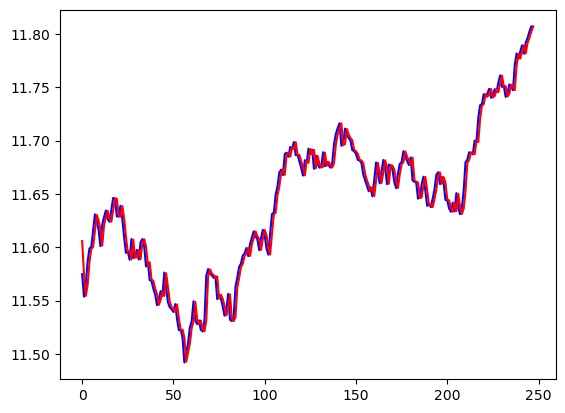

In [85]:
#===============================================================================================================================
# ROLLING ARIMA: LOG - PLOT
#===============================================================================================================================
pyplot.plot(CloseTest, color='blue')
pyplot.plot(PredTest, color='red')
pyplot.show()

In [86]:
#===============================================================================================================================
# ROLLING ARIMA: LOG - SUMMARY
#===============================================================================================================================
print(ARIMA_ROLL_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5942
Model:               SARIMAX(0, 1, 1)   Log Likelihood               15583.437
Date:                Mon, 02 Dec 2024   AIC                         -31162.874
Time:                        15:21:22   BIC                         -31149.495
Sample:                             0   HQIC                        -31158.226
                               - 5942                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0269      0.007     -3.954      0.000      -0.040      -0.014
sigma2         0.0003   2.79e-06    110.686      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.01   Jarque-

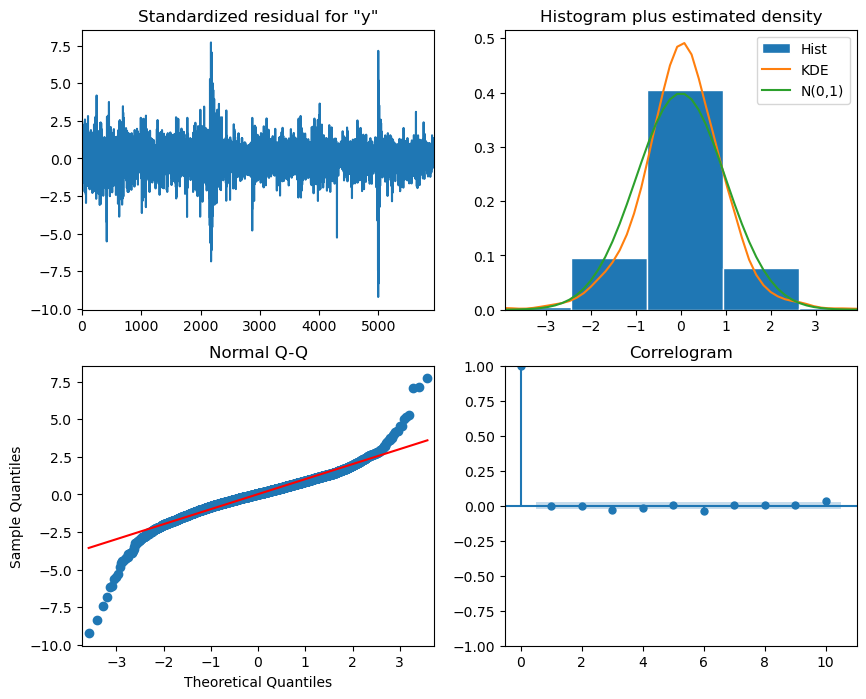

In [87]:
#===============================================================================================================================
# ROLLING ARIMA: LOG - DIAGNOSTICS
#===============================================================================================================================
ARIMA_ROLL_model_fit.plot_diagnostics(figsize=(10,8));

#-------------------------------------------------------------------------------------------------------------------------------
#
# Residuals: No Trend, but Variance is not Constant (discrepancy to White Noise).
# Residuals: Distribution fairly close to a Normal distribution.
# Q-Q plot: Line fairly straight => distribution of Residuals close to a Normal distribution.
# Correlogram: No significant Coefficients after lag 0 => white noise.
#
#-------------------------------------------------------------------------------------------------------------------------------
# ***** WHITE NOISE *****
#-------------------------------------------------------------------------------------------------------------------------------

In [88]:
#===============================================================================================================================
# ROLLING ARIMA: LOG - RESIDUALS - LJUNG-BOX test
#===============================================================================================================================
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm

residuals = ARIMA_ROLL_model_fit.resid
sm.stats.acorr_ljungbox(residuals, lags=[11], return_df=True)
#lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

#-------------------------------------------------------------------------------------------------------------------------------
# LJUNG-BOX test: pvalue > 0.05 => Residuals NOT CORRELATED
#-------------------------------------------------------------------------------------------------------------------------------
# ***** WHITE NOISE => Model can be used to FORECAST *****
#-------------------------------------------------------------------------------------------------------------------------------

,lb_stat,lb_pvalue
11,0.67458,0.999993


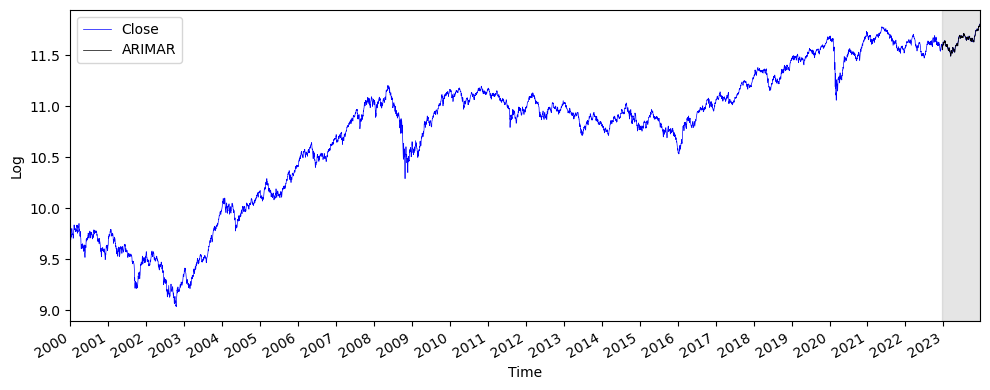

In [89]:
#===============================================================================================================================
# ROLLING ARIMA: LOG - PLOT
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(dfln.loc[       :,'CloseLn']        , 'b-' , label='Close' , lw=0.5)
#ax.plot(dfln.loc[testini:,'pred_LastLn']    , 'y:' , label='Last')
#ax.plot(dfln.loc[testini:,'pred_ARMALn']    , 'w-.', label='ARMA')
ax.plot(dfln.loc[testini:,'pred_ARIMARLn']  , 'k-' , label='ARIMAR', lw=0.5)
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Log')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax.set_xlim(testini, totallen)
plt.xticks(np.arange(0, totallen, testlen), np.arange(2000, 2024, 1))
fig.autofmt_xdate()
plt.tight_layout()

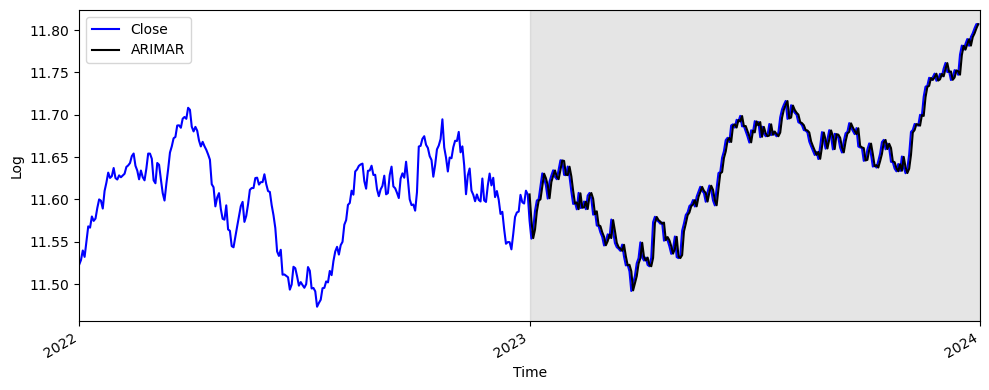

In [90]:
#===============================================================================================================================
# ROLLING ARIMA: LOG - PLOT (zoom)
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(dfln.loc[testini-testlen:,'CloseLn'], 'b-' , label='Close')    
#ax.plot(dfln.loc[testini:,'pred_LastLn']    , 'y:' , label='Last')
#ax.plot(dfln.loc[testini:,'pred_ARMALn']    , 'w-.', label='ARMA')   
ax.plot(dfln.loc[testini:,'pred_ARIMARLn']  , 'k-' , label='ARIMAR')   
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Log')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax.set_xlim(testini-testlen, totallen)
plt.xticks([testini-testlen, testini, totallen ], [ 2022, 2023, 2024])

fig.autofmt_xdate()
plt.tight_layout()

In [91]:
#===============================================================================================================================
# ROLLING ARIMA: PRICE - RECOVER
#===============================================================================================================================
df['pred_ARIMAR'] = 0.0
df.loc[testini:,'pred_ARIMAR']= np.round(np.exp(dfln.loc[testini:,'pred_ARIMARLn']),2)
df[testini-1:]

,Date,Close,pred_Last,pred_Mean,pred_MA,pred_AR,pred_ARMA,pred_ARIMAR
5694,2022-12-29,109734.60,0.00,0.00,0.00,0.00,0.00,0.00
5695,2023-01-02,106376.02,109734.60,55564.15,109747.57,109749.29,109749.29,109747.53
5696,2023-01-03,104165.74,106376.02,55573.07,106470.77,106472.78,106472.78,106470.44
5697,2023-01-04,105334.46,104165.74,55581.60,104229.91,104228.91,104228.91,104229.67
5698,2023-01-05,107641.32,105334.46,55590.33,105303.06,105300.39,105300.39,105303.17
...,...,...,...,...,...,...,...,...
5938,2023-12-21,132182.01,130804.17,57947.47,130831.75,130833.02,130833.02,130831.65
5939,2023-12-22,132752.93,132182.01,57959.97,132145.31,132143.63,132143.63,132145.45
5940,2023-12-26,133532.92,132752.93,57972.56,132736.48,132737.09,132737.09,132736.54
5941,2023-12-27,134193.72,133532.92,57985.28,133511.35,133511.27,133511.27,133511.44


In [92]:
#===============================================================================================================================
# ROLLING ARIMA: PRICE - PERFORMANCE
#===============================================================================================================================
mse_Last   = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_Last'  ])
mse_Mean   = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_Mean'  ])
mse_MA     = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_MA'    ])
mse_AR     = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_AR'    ])
mse_ARMA   = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_ARMA'  ])
#mse_ARIMA  = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_SARIMA'])
#mse_SARIMAS= mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_SARIMAS'])
mse_ARIMAR = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_ARIMAR'])

data_metrics = [['Last'      , "{:,}".format(round(mse_Last,))  , "{:,}".format(round(sqrt(mse_Last)   ,1))] ,
                ['MA'        , "{:,}".format(round(mse_MA,  ))  , "{:,}".format(round(sqrt(mse_MA)     ,1))] ,
                ['AR'        , "{:,}".format(round(mse_AR,  ))  , "{:,}".format(round(sqrt(mse_AR)     ,1))] ,
                ['ARMA'      , "{:,}".format(round(mse_ARMA,))  , "{:,}".format(round(sqrt(mse_ARMA)   ,1))] ,
                ['ARIMAR'    , "{:,}".format(round(mse_ARIMAR,)), "{:,}".format(round(sqrt(mse_ARIMAR) ,1))] ]
 
df_metrics = pd.DataFrame(data_metrics, columns=['Price', 'MSE', 'RMSE'])
df_metrics

,Price,MSE,RMSE
0,Last,"1,476,001","1,214.9"
1,MA,"1,482,822","1,217.7"
2,AR,"1,483,149","1,217.8"
3,ARMA,"1,483,149","1,217.8"
4,ARIMAR,"1,482,795","1,217.7"


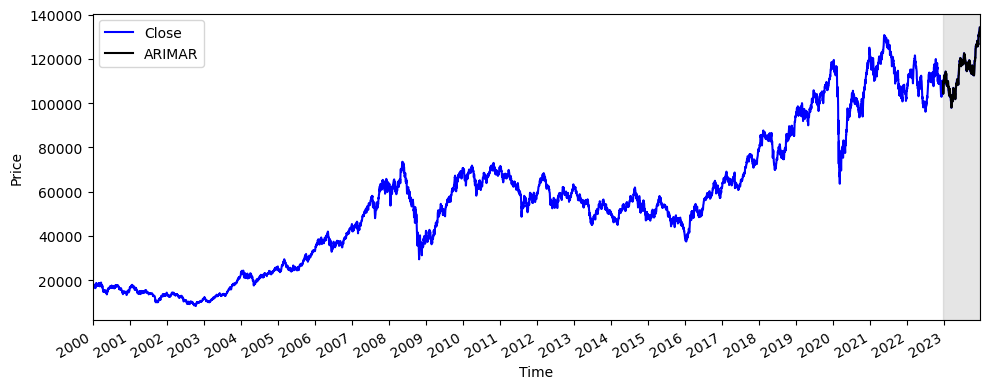

In [93]:
#===============================================================================================================================
# ROLLING ARIMA: PRICE - PLOT
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df['Close'], 'b-', label='Close')    
#ax.plot(df.loc[testini:,'pred_Last']   , 'r-' , label='Last')
#ax.plot(df.loc[testini:,'pred_Mean']   , 'm-.', label='Mean')
#ax.plot(df.loc[testini:,'pred_MA']     , 'y-' , label='MA')
#ax.plot(df.loc[testini:,'pred_AR']     , 'g-.', label='AR')
#ax.plot(df.loc[testini:,'pred_ARMA']   , 'k-' , label='ARMA')
ax.plot(df.loc[testini:,'pred_ARIMAR'] , 'k-' , label='ARIMAR')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax.set_xlim(testini, totallen)
plt.xticks(np.arange(0, totallen, testlen), np.arange(2000, 2024, 1))
fig.autofmt_xdate()
plt.tight_layout()

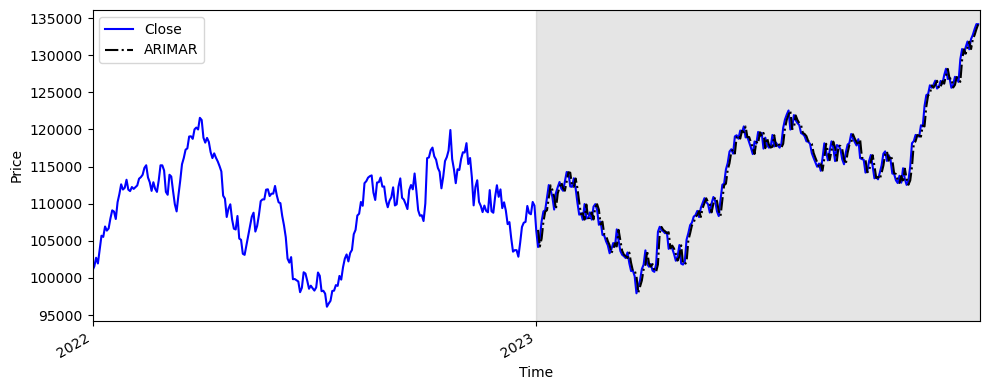

In [94]:
#===============================================================================================================================
# ROLLING ARIMA: PRICE - PLOT (zoom)
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df.loc[testini-PERIOD:,'Close']    , 'b-' , label='Close')
#ax.plot(df.loc[testini+1:  ,'pred_Last']   , 'r-' , label='Last')
#ax.plot(df.loc[testini+1:  ,'pred_Mean']   , 'w-.', label='Mean')
#ax.plot(df.loc[testini+1:  ,'pred_MA']     , 'y-' , label='MA')
#ax.plot(df.loc[testini+1:  ,'pred_AR']     , 'g-.', label='AR')
#ax.plot(df.loc[testini+1:  ,'pred_ARMA']   , 'm-' , label='ARMA')
ax.plot(df.loc[testini+1:  ,'pred_ARIMAR'] , 'k-.', label='ARIMAR')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax.set_xlim(testini, totallen)
plt.xticks([testini-testlen, testini], [2022, 2023])
fig.autofmt_xdate()
plt.tight_layout()

In [95]:
################################################################################################################################
#
# SARIMA - ROLLING ARIMA SEASONAL
#
################################################################################################################################

In [96]:
#===============================================================================================================================
# SARIMAR: LOG - AUTO_ARIMA - AIC
#===============================================================================================================================
import pandas as pd
import pmdarima as pmd

results = pmd.auto_arima(trainLn,
                         start_p=0,  # initial guess for AR(p)
                         start_d=0,  # initial guess for I(d)
                         start_q=0,  # initial guess for MA(q)
                         max_p=4,    # max guess for AR(p)
                         max_d=1,    # max guess for I(d)
                         max_q=4,    # max guess for MA(q)
                         m=21,       # seasonal order
                         start_P=0,  # initial guess for seasonal AR(P)
                         start_D=0,  # initial guess for seasonal I(D)
                         start_Q=0,  # initial guess for seasonal MA(Q)
                         trend='c',
                         information_criterion='aic',
                         trace=True,
                         error_action='ignore'
                         )

#-------------------------------------------------------------------------------------------------------------------------------
# Best model:  ARIMA(0,1,1)(0,0,0)[21] intercept 
# Total fit time: 59.130 seconds
#
#-------------------------------------------------------------------------------------------------------------------------------

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[21] intercept   : AIC=-29713.902, Time=1.22 sec
 ARIMA(1,1,0)(1,0,0)[21] intercept   : AIC=-29715.582, Time=9.04 sec
 ARIMA(0,1,1)(0,0,1)[21] intercept   : AIC=-29715.542, Time=4.37 sec
 ARIMA(0,1,0)(0,0,0)[21]             : AIC=-29713.902, Time=1.65 sec
 ARIMA(1,1,0)(0,0,0)[21] intercept   : AIC=-29716.935, Time=2.37 sec
 ARIMA(1,1,0)(0,0,1)[21] intercept   : AIC=-29715.519, Time=7.63 sec
 ARIMA(1,1,0)(1,0,1)[21] intercept   : AIC=-29713.369, Time=12.05 sec
 ARIMA(2,1,0)(0,0,0)[21] intercept   : AIC=-29714.956, Time=3.02 sec
 ARIMA(1,1,1)(0,0,0)[21] intercept   : AIC=-29715.128, Time=1.92 sec
 ARIMA(0,1,1)(0,0,0)[21] intercept   : AIC=-29716.954, Time=0.87 sec
 ARIMA(0,1,1)(1,0,0)[21] intercept   : AIC=-29715.607, Time=6.79 sec
 ARIMA(0,1,1)(1,0,1)[21] intercept   : AIC=-29713.397, Time=13.09 sec
 ARIMA(0,1,2)(0,0,0)[21] intercept   : AIC=-29715.000, Time=3.23 sec
 ARIMA(1,1,2)(0,0,0)[21] intercept   : AIC=-29713.878, Tim

In [97]:
#===============================================================================================================================
# SARIMAR: LOG - AUTO_ARIMA - BIC
#===============================================================================================================================
results = pmd.auto_arima(trainLn,
                         start_p=0,  # initial guess for AR(p)
                         start_d=0,  # initial guess for I(d)
                         start_q=0,  # initial guess for MA(q)
                         max_p=4,   # max guess for AR(p)
                         max_d=1,    # max guess for I(d)
                         max_q=4,   # max guess for MA(q)
                         m=21,       # seasonal order
                         start_P=0,  # initial guess for seasonal AR(P)
                         start_D=0,  # initial guess for seasonal I(D)
                         start_Q=0,  # initial guess for seasonal MA(Q)
                         trend='c',
                         information_criterion='bic',
                         trace=True,
                         error_action='ignore'
                         )

#-------------------------------------------------------------------------------------------------------------------------------
# Best model:  ARIMA(0,1,0)(0,0,0)[21] intercept
# Total fit time: 21.879 seconds
#-------------------------------------------------------------------------------------------------------------------------------

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[21] intercept   : BIC=-29700.607, Time=2.09 sec
 ARIMA(1,1,0)(1,0,0)[21] intercept   : BIC=-29688.994, Time=7.20 sec
 ARIMA(0,1,1)(0,0,1)[21] intercept   : BIC=-29688.953, Time=3.81 sec
 ARIMA(0,1,0)(0,0,0)[21]             : BIC=-29700.607, Time=1.46 sec
 ARIMA(0,1,0)(1,0,0)[21] intercept   : BIC=-29692.658, Time=2.44 sec
 ARIMA(0,1,0)(0,0,1)[21] intercept   : BIC=-29692.578, Time=3.78 sec
 ARIMA(0,1,0)(1,0,1)[21] intercept   : BIC=-29683.780, Time=6.15 sec
 ARIMA(1,1,0)(0,0,0)[21] intercept   : BIC=-29696.993, Time=3.38 sec
 ARIMA(0,1,1)(0,0,0)[21] intercept   : BIC=-29697.012, Time=0.96 sec
 ARIMA(1,1,1)(0,0,0)[21] intercept   : BIC=-29688.539, Time=2.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[21]          
Total fit time: 33.430 seconds


In [98]:
#===============================================================================================================================
# SARIMAR: LOG - LISTS
#===============================================================================================================================
CloseList = dfln['CloseLn'].values
CloseTrain, CloseTest = CloseList[:testini], CloseList[testini:]
HistTrain = [x for x in CloseTrain]
PredTest = list()

#===============================================================================================================================
# ROLLING ARIMA SEASONAL: LOG - FORECAST
#===============================================================================================================================
for t in range(testlen):
    # AIC - AKAIKE
    SARIMA_ROLL_model = SARIMAX(HistTrain, order=(0,1,1), seasonal_order=(0,0,0,21), simple_differencing=False)
    # BIC - AKAIKE
    #SARIMA_ROLL_model = SARIMAX(HistTrain, order=(0,1,0), seasonal_order=(0,0,0,21), simple_differencing=False)
    
    SARIMA_ROLL_model_fit = SARIMA_ROLL_model.fit(disp=False)

    output = SARIMA_ROLL_model_fit.forecast()
    yhat = output[0]
    PredTest.append(yhat)
    yobs = CloseTest[t]
    #if t>1 : break
    HistTrain.append(yobs)
    print('t = %d, Estimation = %f, Observed = %f' % (t, yhat, yobs))
    dfln.loc[testini+t,'pred_SARIMARLn'] = yhat
    

t = 0, Estimation = 11.605938, Observed = 11.574735
t = 1, Estimation = 11.575623, Observed = 11.553739
t = 2, Estimation = 11.554352, Observed = 11.564896
t = 3, Estimation = 11.564599, Observed = 11.586560
t = 4, Estimation = 11.585944, Observed = 11.598770


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 5, Estimation = 11.598412, Observed = 11.600291
t = 6, Estimation = 11.600239, Observed = 11.615633


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 7, Estimation = 11.615204, Observed = 11.630860
t = 8, Estimation = 11.630426, Observed = 11.624916


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 9, Estimation = 11.625069, Observed = 11.616529
t = 10, Estimation = 11.616766, Observed = 11.601052
t = 11, Estimation = 11.601487, Observed = 11.621234


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 12, Estimation = 11.620684, Observed = 11.628291
t = 13, Estimation = 11.628080, Observed = 11.634452
t = 14, Estimation = 11.634275, Observed = 11.626617
t = 15, Estimation = 11.626830, Observed = 11.623906
t = 16, Estimation = 11.623987, Observed = 11.635392
t = 17, Estimation = 11.635075, Observed = 11.646320


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 18, Estimation = 11.646008, Observed = 11.645510
t = 19, Estimation = 11.645524, Observed = 11.629073
t = 20, Estimation = 11.629529, Observed = 11.628689
t = 21, Estimation = 11.628712, Observed = 11.638946
t = 22, Estimation = 11.638662, Observed = 11.626911
t = 23, Estimation = 11.627237, Observed = 11.609513


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 24, Estimation = 11.610004, Observed = 11.594722
t = 25, Estimation = 11.595142, Observed = 11.596546
t = 26, Estimation = 11.596507, Observed = 11.588309
t = 27, Estimation = 11.588534, Observed = 11.607795
t = 28, Estimation = 11.607263, Observed = 11.589961
t = 29, Estimation = 11.590442, Observed = 11.590611
t = 30, Estimation = 11.590606, Observed = 11.597602


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 31, Estimation = 11.597407, Observed = 11.588486


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 32, Estimation = 11.588734, Observed = 11.604594
t = 33, Estimation = 11.604151, Observed = 11.607703
t = 34, Estimation = 11.607604, Observed = 11.600725
t = 35, Estimation = 11.600917, Observed = 11.582004
t = 36, Estimation = 11.582531, Observed = 11.586110
t = 37, Estimation = 11.586010, Observed = 11.569291
t = 38, Estimation = 11.569757, Observed = 11.568465
t = 39, Estimation = 11.568501, Observed = 11.561067
t = 40, Estimation = 11.561274, Observed = 11.555838
t = 41, Estimation = 11.555990, Observed = 11.545641
t = 42, Estimation = 11.545928, Observed = 11.550857


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 43, Estimation = 11.550720, Observed = 11.558857
t = 44, Estimation = 11.558631, Observed = 11.554335
t = 45, Estimation = 11.554455, Observed = 11.576279
t = 46, Estimation = 11.575670, Observed = 11.562393
t = 47, Estimation = 11.562766, Observed = 11.548468
t = 48, Estimation = 11.548868, Observed = 11.543662
t = 49, Estimation = 11.543807, Observed = 11.541828


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 50, Estimation = 11.541883, Observed = 11.539328


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 51, Estimation = 11.539400, Observed = 11.546695
t = 52, Estimation = 11.546492, Observed = 11.532547
t = 53, Estimation = 11.532937, Observed = 11.522112
t = 54, Estimation = 11.522414, Observed = 11.522857
t = 55, Estimation = 11.522845, Observed = 11.515129


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 56, Estimation = 11.515345, Observed = 11.491971
t = 57, Estimation = 11.492621, Observed = 11.501149
t = 58, Estimation = 11.500911, Observed = 11.509625
t = 59, Estimation = 11.509382, Observed = 11.524707
t = 60, Estimation = 11.524281, Observed = 11.530692
t = 61, Estimation = 11.530514, Observed = 11.549387
t = 62, Estimation = 11.548865, Observed = 11.531573
t = 63, Estimation = 11.532054, Observed = 11.527875
t = 64, Estimation = 11.527991, Observed = 11.531447
t = 65, Estimation = 11.531351, Observed = 11.522656
t = 66, Estimation = 11.522898, Observed = 11.521109
t = 67, Estimation = 11.521159, Observed = 11.531223
t = 68, Estimation = 11.530943, Observed = 11.573209
t = 69, Estimation = 11.572042, Observed = 11.579553
t = 70, Estimation = 11.579347, Observed = 11.575504
t = 71, Estimation = 11.575610, Observed = 11.573826
t = 72, Estimation = 11.573875, Observed = 11.571342
t = 73, Estimation = 11.571412, Observed = 11.572733
t = 74, Estimation = 11.572697, Observed = 11.

C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 76, Estimation = 11.555563, Observed = 11.551632


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 77, Estimation = 11.551741, Observed = 11.544619
t = 78, Estimation = 11.544815, Observed = 11.535783
t = 79, Estimation = 11.536031, Observed = 11.541739
t = 80, Estimation = 11.541583, Observed = 11.556288
t = 81, Estimation = 11.555884, Observed = 11.532012
t = 82, Estimation = 11.532671, Observed = 11.530737
t = 83, Estimation = 11.530790, Observed = 11.534436
t = 84, Estimation = 11.534335, Observed = 11.563129
t = 85, Estimation = 11.562335, Observed = 11.571592


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 86, Estimation = 11.571338, Observed = 11.581646
t = 87, Estimation = 11.581364, Observed = 11.584764
t = 88, Estimation = 11.584671, Observed = 11.592258
t = 89, Estimation = 11.592051, Observed = 11.594172
t = 90, Estimation = 11.594114, Observed = 11.599370
t = 91, Estimation = 11.599227, Observed = 11.591678


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 92, Estimation = 11.591885, Observed = 11.603314
t = 93, Estimation = 11.603001, Observed = 11.609221


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 94, Estimation = 11.609051, Observed = 11.614981
t = 95, Estimation = 11.614819, Observed = 11.610171
t = 96, Estimation = 11.610298, Observed = 11.607586
t = 97, Estimation = 11.607660, Observed = 11.597262
t = 98, Estimation = 11.597546, Observed = 11.608730
t = 99, Estimation = 11.608424, Observed = 11.616434
t = 100, Estimation = 11.616215, Observed = 11.611262
t = 101, Estimation = 11.611397, Observed = 11.598801
t = 102, Estimation = 11.599145, Observed = 11.592984
t = 103, Estimation = 11.593152, Observed = 11.613356
t = 104, Estimation = 11.612803, Observed = 11.631225
t = 105, Estimation = 11.630725, Observed = 11.632452
t = 106, Estimation = 11.632405, Observed = 11.649291
t = 107, Estimation = 11.648834, Observed = 11.656923
t = 108, Estimation = 11.656705, Observed = 11.670096
t = 109, Estimation = 11.669735, Observed = 11.672800


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 110, Estimation = 11.672717, Observed = 11.667728
t = 111, Estimation = 11.667862, Observed = 11.687457
t = 112, Estimation = 11.686927, Observed = 11.688734
t = 113, Estimation = 11.688685, Observed = 11.684847
t = 114, Estimation = 11.684950, Observed = 11.694061
t = 115, Estimation = 11.693815, Observed = 11.692095
t = 116, Estimation = 11.692142, Observed = 11.698743
t = 117, Estimation = 11.698565, Observed = 11.686326


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 118, Estimation = 11.686657, Observed = 11.686686


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 119, Estimation = 11.686686, Observed = 11.680497
t = 120, Estimation = 11.680664, Observed = 11.674388
t = 121, Estimation = 11.674558, Observed = 11.667202
t = 122, Estimation = 11.667400, Observed = 11.681677
t = 123, Estimation = 11.681291, Observed = 11.679177
t = 124, Estimation = 11.679234, Observed = 11.692516
t = 125, Estimation = 11.692156, Observed = 11.687520
t = 126, Estimation = 11.687646, Observed = 11.691483
t = 127, Estimation = 11.691379, Observed = 11.673561


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 128, Estimation = 11.674045, Observed = 11.686021
t = 129, Estimation = 11.685694, Observed = 11.677952
t = 130, Estimation = 11.678164, Observed = 11.674666


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 131, Estimation = 11.674762, Observed = 11.675610
t = 132, Estimation = 11.675586, Observed = 11.689094
t = 133, Estimation = 11.688725, Observed = 11.675984
t = 134, Estimation = 11.676333, Observed = 11.680298
t = 135, Estimation = 11.680189, Observed = 11.677093
t = 136, Estimation = 11.677178, Observed = 11.674637
t = 137, Estimation = 11.674706, Observed = 11.679142
t = 138, Estimation = 11.679020, Observed = 11.697052
t = 139, Estimation = 11.696557, Observed = 11.706366
t = 140, Estimation = 11.706098, Observed = 11.711840
t = 141, Estimation = 11.711683, Observed = 11.716359
t = 142, Estimation = 11.716232, Observed = 11.695161
t = 143, Estimation = 11.695736, Observed = 11.696805
t = 144, Estimation = 11.696776, Observed = 11.711309
t = 145, Estimation = 11.710912, Observed = 11.705597
t = 146, Estimation = 11.705742, Observed = 11.702378


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 147, Estimation = 11.702470, Observed = 11.700117


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 148, Estimation = 11.700181, Observed = 11.691136
t = 149, Estimation = 11.691383, Observed = 11.690063
t = 150, Estimation = 11.690099, Observed = 11.687637


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 151, Estimation = 11.687704, Observed = 11.681898
t = 152, Estimation = 11.682057, Observed = 11.681398
t = 153, Estimation = 11.681416, Observed = 11.678992
t = 154, Estimation = 11.679058, Observed = 11.668300


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 155, Estimation = 11.668594, Observed = 11.662822
t = 156, Estimation = 11.662980, Observed = 11.657818
t = 157, Estimation = 11.657959, Observed = 11.652533


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 158, Estimation = 11.652681, Observed = 11.656233
t = 159, Estimation = 11.656137, Observed = 11.647713
t = 160, Estimation = 11.647943, Observed = 11.662689
t = 161, Estimation = 11.662286, Observed = 11.679580
t = 162, Estimation = 11.679109, Observed = 11.670148
t = 163, Estimation = 11.670393, Observed = 11.659941
t = 164, Estimation = 11.660226, Observed = 11.670963
t = 165, Estimation = 11.670670, Observed = 11.681854
t = 166, Estimation = 11.681550, Observed = 11.674492
t = 167, Estimation = 11.674685, Observed = 11.659117


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 168, Estimation = 11.659541, Observed = 11.677532
t = 169, Estimation = 11.677040, Observed = 11.676545
t = 170, Estimation = 11.676559, Observed = 11.672757
t = 171, Estimation = 11.672861, Observed = 11.661219


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 172, Estimation = 11.661538, Observed = 11.655409
t = 173, Estimation = 11.655576, Observed = 11.668932
t = 174, Estimation = 11.668566, Observed = 11.678170
t = 175, Estimation = 11.677908, Observed = 11.679930


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 176, Estimation = 11.679875, Observed = 11.690164
t = 177, Estimation = 11.689883, Observed = 11.684839


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 178, Estimation = 11.684977, Observed = 11.680879
t = 179, Estimation = 11.680991, Observed = 11.677132


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 180, Estimation = 11.677237, Observed = 11.684315


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 181, Estimation = 11.684122, Observed = 11.662595
t = 182, Estimation = 11.663185, Observed = 11.661420
t = 183, Estimation = 11.661468, Observed = 11.660695
t = 184, Estimation = 11.660716, Observed = 11.645649


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 185, Estimation = 11.646061, Observed = 11.646818
t = 186, Estimation = 11.646798, Observed = 11.659022
t = 187, Estimation = 11.658687, Observed = 11.666206


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 188, Estimation = 11.666000, Observed = 11.653182
t = 189, Estimation = 11.653533, Observed = 11.638845


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 190, Estimation = 11.639245, Observed = 11.640504
t = 191, Estimation = 11.640470, Observed = 11.637654
t = 192, Estimation = 11.637731, Observed = 11.645441
t = 193, Estimation = 11.645230, Observed = 11.654044
t = 194, Estimation = 11.653803, Observed = 11.667678
t = 195, Estimation = 11.667301, Observed = 11.670363
t = 196, Estimation = 11.670280, Observed = 11.659223
t = 197, Estimation = 11.659524, Observed = 11.665937
t = 198, Estimation = 11.665763, Observed = 11.660556
t = 199, Estimation = 11.660698, Observed = 11.644477
t = 200, Estimation = 11.644918, Observed = 11.643991
t = 201, Estimation = 11.644017, Observed = 11.636516
t = 202, Estimation = 11.636720, Observed = 11.633234


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 203, Estimation = 11.633329, Observed = 11.641863
t = 204, Estimation = 11.641631, Observed = 11.633637


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 205, Estimation = 11.633855, Observed = 11.650745
t = 206, Estimation = 11.650284, Observed = 11.637806


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 207, Estimation = 11.638148, Observed = 11.630989
t = 208, Estimation = 11.631184, Observed = 11.636414
t = 209, Estimation = 11.636271, Observed = 11.653148


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 210, Estimation = 11.652687, Observed = 11.679795


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 211, Estimation = 11.679061, Observed = 11.682088
t = 212, Estimation = 11.682006, Observed = 11.689129


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 213, Estimation = 11.688936, Observed = 11.688362


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 214, Estimation = 11.688378, Observed = 11.687166
t = 215, Estimation = 11.687198, Observed = 11.699970
t = 216, Estimation = 11.699625, Observed = 11.698659
t = 217, Estimation = 11.698685, Observed = 11.721286
t = 218, Estimation = 11.720675, Observed = 11.733179
t = 219, Estimation = 11.732843, Observed = 11.734253
t = 220, Estimation = 11.734215, Observed = 11.743696
t = 221, Estimation = 11.743442, Observed = 11.741065
t = 222, Estimation = 11.741129, Observed = 11.744317
t = 223, Estimation = 11.744232, Observed = 11.748596
t = 224, Estimation = 11.748479, Observed = 11.740199
t = 225, Estimation = 11.740421, Observed = 11.741904
t = 226, Estimation = 11.741864, Observed = 11.748300
t = 227, Estimation = 11.748127, Observed = 11.745351
t = 228, Estimation = 11.745426, Observed = 11.754546
t = 229, Estimation = 11.754301, Observed = 11.761229
t = 230, Estimation = 11.761043, Observed = 11.750388
t = 231, Estimation = 11.750675, Observed = 11.751180
t = 232, Estimation = 11.751

C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 235, Estimation = 11.752446, Observed = 11.751284
t = 236, Estimation = 11.751315, Observed = 11.747231
t = 237, Estimation = 11.747341, Observed = 11.771166


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 238, Estimation = 11.770523, Observed = 11.781746


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 239, Estimation = 11.781445, Observed = 11.776805
t = 240, Estimation = 11.776929, Observed = 11.783592


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 241, Estimation = 11.783413, Observed = 11.789427
t = 242, Estimation = 11.789265, Observed = 11.781457
t = 243, Estimation = 11.781667, Observed = 11.791935
t = 244, Estimation = 11.791658, Observed = 11.796245


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


t = 245, Estimation = 11.796122, Observed = 11.802103
t = 246, Estimation = 11.801942, Observed = 11.807040
t = 247, Estimation = 11.806903, Observed = 11.806977


C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


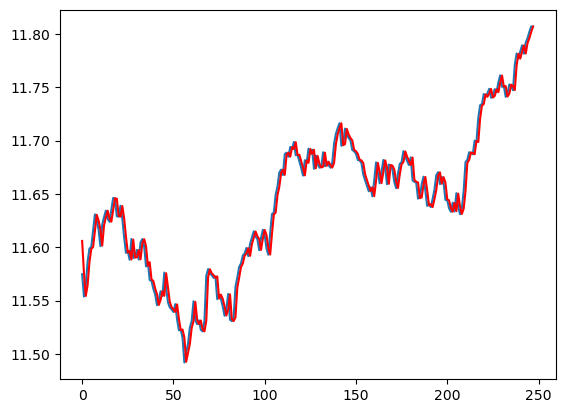

In [99]:
#===============================================================================================================================
# SARIMAR: LOG - PLOT
#===============================================================================================================================
pyplot.plot(CloseTest)
pyplot.plot(PredTest, color='red')
pyplot.show()


In [100]:
#===============================================================================================================================
# SARIMAR: LOG - SUMMARY
#===============================================================================================================================
print(SARIMA_ROLL_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5942
Model:               SARIMAX(0, 1, 1)   Log Likelihood               15583.437
Date:                Mon, 02 Dec 2024   AIC                         -31162.874
Time:                        15:26:29   BIC                         -31149.495
Sample:                             0   HQIC                        -31158.226
                               - 5942                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0269      0.007     -3.954      0.000      -0.040      -0.014
sigma2         0.0003   2.79e-06    110.686      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.01   Jarque-

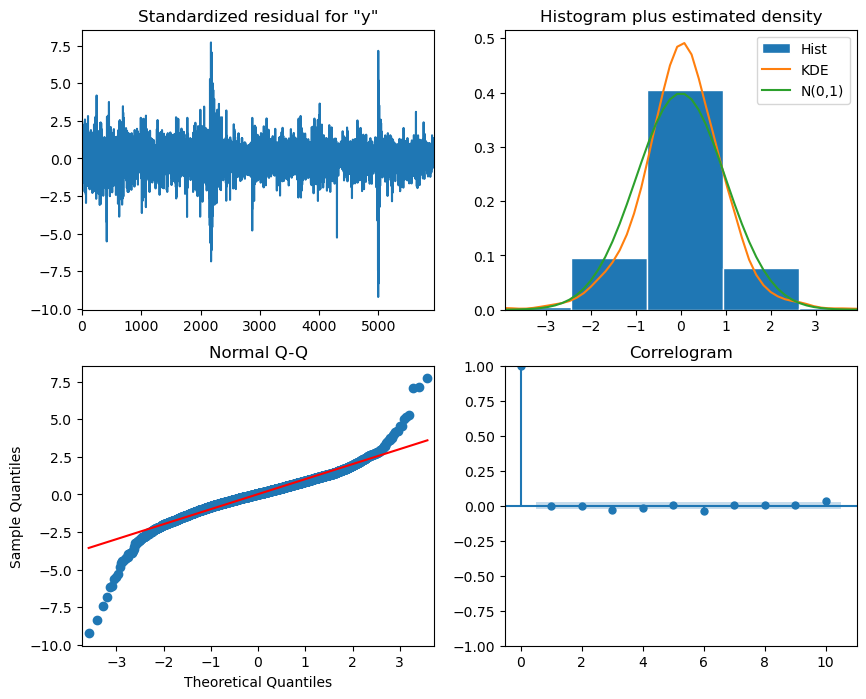

In [101]:
#===============================================================================================================================
# SARIMAR: LOG - DIAGNOSTICS
#===============================================================================================================================
SARIMA_ROLL_model_fit.plot_diagnostics(figsize=(10,8));

#-------------------------------------------------------------------------------------------------------------------------------
#
# Residuals: No Trend, but Variance is not Constant (discrepancy to White Noise).
# Residuals: Distribution fairly close to a Normal distribution.
# Q-Q plot: Line fairly straight => distribution of Residuals close to a Normal distribution.
# Correlogram: Only one significant Coefficients after lag 0, at lag 9 => close to White Noise.
#
# ***** ~ WHITE NOISE *****
#-------------------------------------------------------------------------------------------------------------------------------

In [102]:
#===============================================================================================================================
# SARIMAR: LOG - RESIDUALS - LJUNG-BOX test
#===============================================================================================================================
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
#residuals = model_fit.resid
residuals = SARIMA_ROLL_model_fit.resid
sm.stats.acorr_ljungbox(residuals, lags=[11], return_df=True)
#lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

#-------------------------------------------------------------------------------------------------------------------------------
# LJUNG-BOX test: pvalue > 0.05 => Residuals NOT CORRELATED.
#-------------------------------------------------------------------------------------------------------------------------------
# ***** WHITE NOISE => Model can be used to FORECAST *****
#-------------------------------------------------------------------------------------------------------------------------------

,lb_stat,lb_pvalue
11,0.67458,0.999993


In [103]:
#===============================================================================================================================
# SARIMAR: LOG - RESULTS
#===============================================================================================================================
#dfln.rename(columns={"pred_SARIMAS_ROLLLn": "pred_SARIMARLn"}, inplace=True)
dfln[testini-1:]


,Date,Close,CloseLn,CloseLnDiff,pred_LastLn,pred_MeanLn,pred_MALn,pred_ARLn,pred_ARMALn,pred_ARIMARLn,pred_SARIMARLn
5694,2022-12-29,109734.60,11.605820,-0.004565,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
5695,2023-01-02,106376.02,11.574735,-0.031085,11.605820,10.729549,11.605938,11.605954,11.605954,11.605938,11.605938
5696,2023-01-03,104165.74,11.553739,-0.020997,11.574735,10.729697,11.575626,11.575645,11.575645,11.575623,11.575623
5697,2023-01-04,105334.46,11.564896,0.011157,11.553739,10.729842,11.554354,11.554345,11.554345,11.554352,11.554352
5698,2023-01-05,107641.32,11.586560,0.021664,11.564896,10.729988,11.564598,11.564572,11.564572,11.564599,11.564599
...,...,...,...,...,...,...,...,...,...,...,...
5938,2023-12-21,132182.01,11.791935,0.010479,11.781457,10.766810,11.781667,11.781677,11.781677,11.781667,11.781667
5939,2023-12-22,132752.93,11.796245,0.004310,11.791935,10.766983,11.791657,11.791645,11.791645,11.791658,11.791658
5940,2023-12-26,133532.92,11.802103,0.005858,11.796245,10.767156,11.796121,11.796126,11.796126,11.796122,11.796122
5941,2023-12-27,134193.72,11.807040,0.004936,11.802103,10.767330,11.801942,11.801941,11.801941,11.801942,11.801942


In [104]:
#===============================================================================================================================
# SARIMAR: LOG - PERFORMANCE
#===============================================================================================================================
from sklearn.metrics import mean_squared_error
from math import sqrt

mse_Last        = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_LastLn'])
mse_Mean        = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_MeanLn'])
mse_MA          = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_MALn'  ])
mse_AR          = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_ARLn'  ])
mse_ARMA        = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_ARMALn'])
#mse_ARIMA       = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_ARIMALn' ])
#mse_SARIMA      = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_SARIMALn'])
#mse_SARIMAS     = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_SARIMASLn'])
mse_ARIMAR      = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_ARIMARLn'])
mse_SARIMAR     = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_SARIMARLn'])

data_metrics = [['Last'       , "{:,}".format(round(mse_Last       ,6)), "{:,}".format(round(sqrt(mse_Last)       ,6))] ,
                ['Mean'       , "{:,}".format(round(mse_Mean       ,6)), "{:,}".format(round(sqrt(mse_Mean)       ,6))] ,
                ['MA'         , "{:,}".format(round(mse_MA         ,6)), "{:,}".format(round(sqrt(mse_MA)         ,6))] ,
                ['AR'         , "{:,}".format(round(mse_AR         ,6)), "{:,}".format(round(sqrt(mse_AR)         ,6))] ,
                ['ARMA'       , "{:,}".format(round(mse_ARMA       ,6)), "{:,}".format(round(sqrt(mse_ARMA)       ,6))] ,
                ['ARIMAR'     , "{:,}".format(round(mse_ARIMAR     ,6)), "{:,}".format(round(sqrt(mse_ARIMAR)     ,6))] ,
                ['SARIMAR'    , "{:,}".format(round(mse_SARIMAR    ,6)), "{:,}".format(round(sqrt(mse_SARIMAR)    ,6))] ]

df_metrics = pd.DataFrame(data_metrics, columns=['Log', 'MSE', 'RMSE'])

C:\Users\55119\AppData\Local\Temp\ipykernel_15036\3875864436.py:14: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(testini, totallen-testlen)


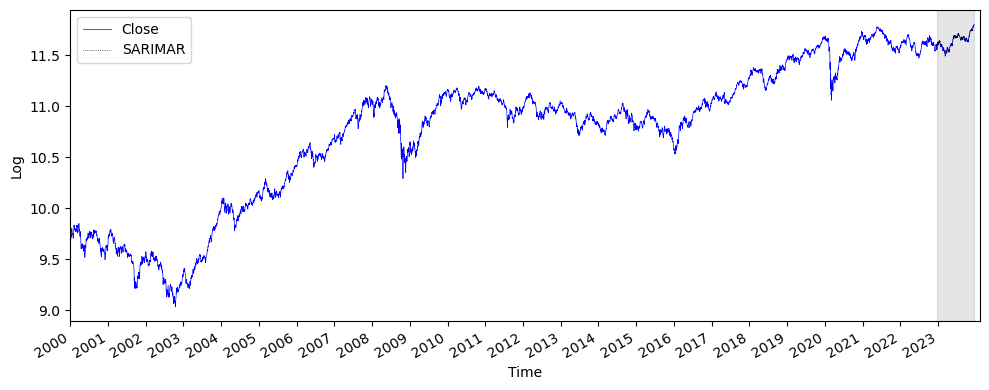

In [105]:
#===============================================================================================================================
# SARIMAR: LOG - PLOT
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(dfln.loc[:,'CloseLn']               , 'b-', label='Close', lw=0.5)
#ax.plot(dfln.loc[testini:,'pred_LastLn']    , 'r:', label='Last')
#ax.plot(dfln.loc[testini:,'pred_ARMALn']    , 'g-', label='ARMA roll')   
#ax.plot(dfln.loc[testini:,'pred_ARIMARLn']  , 'm-', label='ARIMAR')   
ax.plot(dfln.loc[testini:,'pred_SARIMARLn'] , 'k:', label='SARIMAR', lw=0.5)
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Log')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax.set_xlim(testini, totallen-testlen)
plt.xticks(np.arange(0, totallen, testlen), np.arange(2000, 2024, 1))
fig.autofmt_xdate()
plt.tight_layout()

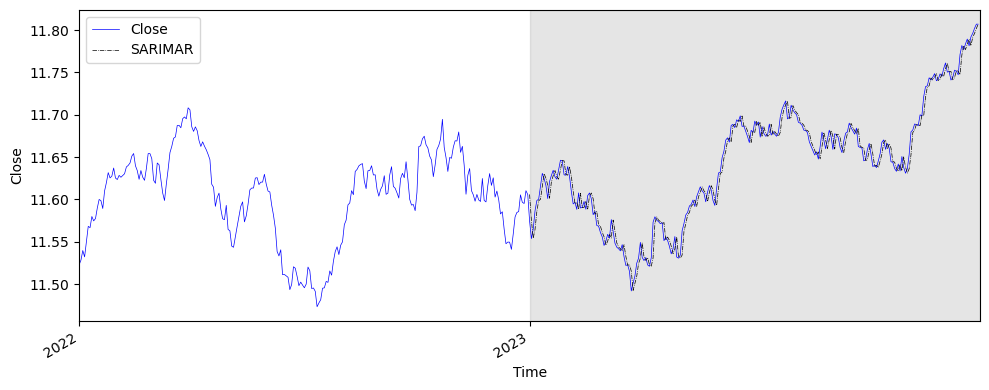

In [106]:
#===============================================================================================================================
# SARIMAR: LOG - PLOT (zoom)
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(dfln.loc[testini-testlen: ,'CloseLn']        , 'b-',  label='Close' , lw=0.5)    
#ax.plot(dfln.loc[testini:         ,'pred_LastLn']    , 'y:',  label='Last')    
#ax.plot(dfln.loc[testini:         ,'pred_ARMALn']    , 'm-.', label='ARMA')   
#ax.plot(dfln.loc[testini:         ,'pred_ARIMALn']   , 'm-.', label='ARIMA')   
#ax.plot(dfln.loc[testini:         ,'pred_ARIMARLn']  , 'r-.', label='ARIMAR')   
ax.plot(dfln.loc[testini:         ,'pred_SARIMARLn'] , 'k-.', label='SARIMAR', lw=0.5)   
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Close')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax.set_xlim(testini-testlen, totallen) 
plt.xticks([ testini-testlen, testini ], [ 2022           , 2023])
fig.autofmt_xdate()
plt.tight_layout()

In [107]:
#===============================================================================================================================
# SARIMAR: PRICE - RECOVER
#===============================================================================================================================
df['pred_SARIMAR'] = 0.0
df.loc[testini:,'pred_SARIMAR']= np.round(np.exp(dfln.loc[testini:,'pred_SARIMARLn']),2)
dfln.loc[testini:,'pred_SARIMARLn'].to_excel('Data/Output/Rolling-Ln-Daily-SARIMARLn.xlsx')
df[testini-1:]

,Date,Close,pred_Last,pred_Mean,pred_MA,pred_AR,pred_ARMA,pred_ARIMAR,pred_SARIMAR
5694,2022-12-29,109734.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5695,2023-01-02,106376.02,109734.60,55564.15,109747.57,109749.29,109749.29,109747.53,109747.53
5696,2023-01-03,104165.74,106376.02,55573.07,106470.77,106472.78,106472.78,106470.44,106470.44
5697,2023-01-04,105334.46,104165.74,55581.60,104229.91,104228.91,104228.91,104229.67,104229.67
5698,2023-01-05,107641.32,105334.46,55590.33,105303.06,105300.39,105300.39,105303.17,105303.17
...,...,...,...,...,...,...,...,...,...
5938,2023-12-21,132182.01,130804.17,57947.47,130831.75,130833.02,130833.02,130831.65,130831.65
5939,2023-12-22,132752.93,132182.01,57959.97,132145.31,132143.63,132143.63,132145.45,132145.45
5940,2023-12-26,133532.92,132752.93,57972.56,132736.48,132737.09,132737.09,132736.54,132736.54
5941,2023-12-27,134193.72,133532.92,57985.28,133511.35,133511.27,133511.27,133511.44,133511.44


In [108]:
#===============================================================================================================================
# SARIMAR: PRICE - PERFORMANCE
#===============================================================================================================================
mse_Last   = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_Last'   ])
mse_Mean   = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_Mean'   ])
mse_MA     = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_MA'     ])
mse_AR     = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_AR'     ])
mse_ARMA   = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_ARMA'   ])
mse_ARIMAR = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_ARIMAR' ])
mse_SARIMAR= mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_SARIMAR'])

data_metrics = [['Last'      , "{:,}".format(round(mse_Last,))   , "{:,}".format(round(sqrt(mse_Last)   ,2))] ,
                ['MA'        , "{:,}".format(round(mse_MA,  ))   , "{:,}".format(round(sqrt(mse_MA)     ,2))] ,
                ['AR'        , "{:,}".format(round(mse_AR,  ))   , "{:,}".format(round(sqrt(mse_AR)     ,2))] ,
                ['ARMA'      , "{:,}".format(round(mse_ARMA,))   , "{:,}".format(round(sqrt(mse_ARMA)   ,2))] ,
                ['ARIMAR'    , "{:,}".format(round(mse_ARIMAR,)) , "{:,}".format(round(sqrt(mse_ARIMAR) ,2))] ,
                ['SARIMAR'   , "{:,}".format(round(mse_SARIMAR,)), "{:,}".format(round(sqrt(mse_SARIMAR),2))] ]
 
df_metrics = pd.DataFrame(data_metrics, columns=['Price', 'MSE', 'RMSE'])
df_metrics

,Price,MSE,RMSE
0,Last,"1,476,001","1,214.91"
1,MA,"1,482,822","1,217.71"
2,AR,"1,483,149","1,217.85"
3,ARMA,"1,483,149","1,217.85"
4,ARIMAR,"1,482,795","1,217.7"
5,SARIMAR,"1,482,795","1,217.7"


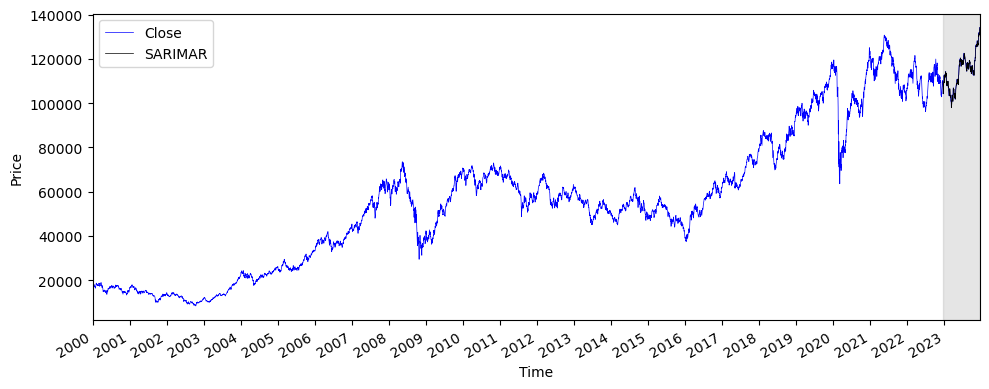

In [109]:
#===============================================================================================================================
# SARIMAR: PRICE - PLOT
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df['Close'], 'b-', label='Close', lw=0.5)    
#ax.plot(df.loc[testini:,'pred_Last']     , 'r-' , label='Last'    )
#ax.plot(df.loc[testini:,'pred_Mean']     , 'm-.', label='Mean'    )
#ax.plot(df.loc[testini:,'pred_MA']       , 'y-' , label='MA'      )   
#ax.plot(df.loc[testini:,'pred_AR']       , 'g-.', label='AR'      )   
#ax.plot(df.loc[testini:,'pred_ARMA']     , 'w-' , label='ARMA'    )   
#ax.plot(df.loc[testini:,'pred_ARIMAR']   , 'g-' , label='ARIMAR'  )   
ax.plot(df.loc[testini:,'pred_SARIMAR']  , 'k-' , label='SARIMAR' , lw=0.5)
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax.set_xlim(testini, totallen)
plt.xticks(np.arange(0, totallen, testlen), np.arange(2000, 2024, 1))
fig.autofmt_xdate()
plt.tight_layout()

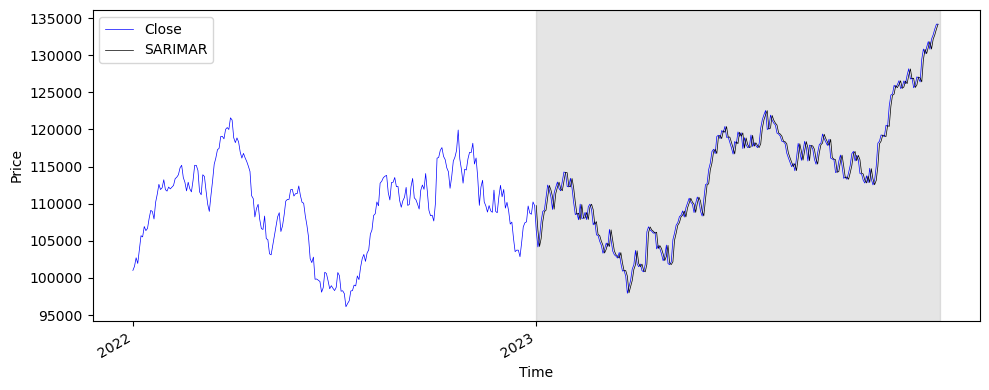

In [110]:
#===============================================================================================================================
# SARIMAR: PRICE - PLOT (zoom)
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df.loc[testini-testlen:,'Close'] , 'b-' , label='Close' , lw=0.5)    
#ax.plot(df.loc[testini:,'pred_Last']     , 'r-' , label='Last')
#ax.plot(df.loc[testini:,'pred_Mean']     , 'm-.', label='Mean')
#ax.plot(df.loc[testini:,'pred_MA']       , 'y-' , label='MA')   
#ax.plot(df.loc[testini:,'pred_AR']       , 'g-.', label='AR')   
#ax.plot(df.loc[testini:,'pred_ARMA']     , 'w-' , label='ARMA')   
#ax.plot(df.loc[testini:,'pred_ARIMAR']   , 'g-' , label='ARIMAR')   
ax.plot(df.loc[testini:,'pred_SARIMAR']  , 'k-' , label='SARIMAR' , lw=0.5)
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
#ax.set_xlim(testini, totallen)
plt.xticks([ testini-testlen, testini],           ['2022'          , '2023'])
fig.autofmt_xdate()
plt.tight_layout()

